# Cross-Order Effect Analysis

This notebook analyzes cross-order effects: When instructions are created with one example order (ascending/descending), how do they perform when tested with the same order vs. the opposite order?

## Key Questions
- Do instructions created with ascending order perform better when tested with ascending order?
- Are instructions order-agnostic?
- How do different modalities compare in terms of order sensitivity?


In [1]:
# Setup and Imports
import json
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Dict, List, Any
import numpy as np
import pandas as pd

# For Jupyter notebooks, plots will display inline automatically
# If you need to save plots, they will be saved to files as well

# Configuration
MODALITY_TYPES = [
    "row_only",
    "col_only",
    "image_only",
    "row_col",
    "row_image",
    "col_image",
    "row_col_image",
]

# New JSON-based modalities (ascending order only)
JSON_MODALITY_TYPES = [
    "json_only",
    "row_col_json",
    "row_col_json_image",
    "image_json",
]

# Set up paths (adjust if needed)
NOTEBOOK_DIR = Path(".").resolve()
RESULTS_FILE = NOTEBOOK_DIR / "results.json"
PLOTS_DIR = NOTEBOOK_DIR / "plots"
PLOTS_DIR.mkdir(exist_ok=True)

print(f"Notebook directory: {NOTEBOOK_DIR}")
print(f"Results file: {RESULTS_FILE}")
print(f"Plots directory: {PLOTS_DIR}")


Notebook directory: /home/bwen/projects/arc-aif-agi/modality_experiment_results/13e47133/20251105_1142
Results file: /home/bwen/projects/arc-aif-agi/modality_experiment_results/13e47133/20251105_1142/results.json
Plots directory: /home/bwen/projects/arc-aif-agi/modality_experiment_results/13e47133/20251105_1142/plots


## 1. Load Dataset


In [2]:
# Load results.json file
def load_results(results_file: Path) -> Dict[str, Any]:
    """Load results.json file."""
    with open(results_file, "r") as f:
        return json.load(f)

# Load the data
summary = load_results(RESULTS_FILE)
results = summary.get("results", [])

# Load new JSON-based experiment results
NEW_RESULTS_DIRS = [
    NOTEBOOK_DIR.parent / "20251108_1435",  # json_only
    NOTEBOOK_DIR.parent / "20251108_1444",  # row_col_json
    NOTEBOOK_DIR.parent / "20251108_1455",  # row_col_json_image
    NOTEBOOK_DIR.parent / "20251108_1504",  # image_json
]

new_results = []
for results_dir in NEW_RESULTS_DIRS:
    results_file = results_dir / "results.json"
    if results_file.exists():
        try:
            new_summary = load_results(results_file)
            # Convert to the format expected by extract_cross_order_scores
            # These are ascending-only experiments, so we'll treat them specially
            new_results.append(new_summary)
        except Exception as e:
            print(f"Warning: Could not load {results_file}: {e}")

# Load repeat sampling experiment (20251108_2058) - row_col_json_image asc, 4 trials with t=0.7
REPEAT_SAMPLING_DIR = NOTEBOOK_DIR.parent / "20251108_2058"
repeat_sampling_results = []
if REPEAT_SAMPLING_DIR.exists():
    results_file = REPEAT_SAMPLING_DIR / "results_combined.json"
    if results_file.exists():
        try:
            repeat_summary = load_results(results_file)
            repeat_sampling_results.append(repeat_summary)
            print(f"Loaded repeat sampling experiment: {len(repeat_summary.get('trials', []))} trials")
        except Exception as e:
            print(f"Warning: Could not load {results_file}: {e}")
else:
    print(f"Warning: Repeat sampling directory not found: {REPEAT_SAMPLING_DIR}")

print(f"Loaded {len(results)} original experiment results")
print(f"Loaded {len(new_results)} new JSON-based experiment results")
print(f"Session ID: {summary.get('session_id', 'N/A')}")
print(f"Model: {summary.get('model', 'N/A')}")
print(f"Temperature: {summary.get('temperature', 'N/A')}")
print(f"Number of training examples: {summary.get('num_train', 'N/A')}")
print(f"Number of test cases: {summary.get('num_test', 'N/A')}")

# Show available modalities
modalities_found = set(r.get("modality_type") for r in results if "error" not in r)
for new_summary in new_results:
    modality = new_summary.get("modality_type") or new_summary.get("result", {}).get("modality_type")
    if modality:
        modalities_found.add(modality)
print(f"\nAvailable modalities: {sorted(modalities_found)}")


Loaded repeat sampling experiment: 4 trials
Loaded 14 original experiment results
Loaded 4 new JSON-based experiment results
Session ID: 13e47133-modality_experiment-20251105_1142
Model: gemini/gemini-2.5-pro
Temperature: 0.3
Number of training examples: 3
Number of test cases: 2

Available modalities: ['col_image', 'col_only', 'image_json', 'image_only', 'json_only', 'row_col', 'row_col_image', 'row_col_json', 'row_col_json_image', 'row_image', 'row_only']


## 2. Extract Cross-Order Data


In [3]:
# Extract cross-order scores from results
def extract_cross_order_scores(results: List[Dict[str, Any]], new_summaries: List[Dict[str, Any]] = None) -> Dict[str, Dict[str, List[Dict[str, Any]]]]:
    """
    Extract cross-order scores from results.
    
    Args:
        results: List of original cross-order experiment results
        new_summaries: List of new ascending-only experiment summaries
    
    Returns:
        Dict with structure:
        {
            modality: {
                "held_out": [{asc_score, desc_score, hypothesis_order, held_out_idx}, ...],
                "test": [{asc_score, desc_score, hypothesis_order, test_idx}, ...],
                "held_out_reduced": [...],
                "test_reduced": [...]
            }
        }
    """
    cross_order_data = {}
    
    # Process original cross-order results
    for result in results:
        if "error" in result:
            continue
        
        modality = result["modality_type"]
        hypothesis_order = result["example_order"]  # Order used to GENERATE hypothesis
        
        if modality not in cross_order_data:
            cross_order_data[modality] = {
                "held_out": [],
                "test": [],
                "held_out_reduced": [],
                "test_reduced": [],
                "hypothesis_order": {}  # Track which order was used for hypothesis generation
            }
        
        # Store hypothesis order info
        cross_order_data[modality]["hypothesis_order"][hypothesis_order] = True
        
        # Extract held-out results (normal)
        for ho_result in result.get("held_out_results", []):
            if "error" not in ho_result:
                asc_score = ho_result.get("ascending", {}).get("similarity", 0.0)
                desc_score = ho_result.get("descending", {}).get("similarity", 0.0)
                cross_order_data[modality]["held_out"].append({
                    "asc_score": asc_score,
                    "desc_score": desc_score,
                    "hypothesis_order": hypothesis_order,
                    "held_out_idx": ho_result.get("held_out_idx")
                })
        
        # Extract test results (normal)
        for test_result in result.get("test_results", []):
            if "error" not in test_result:
                asc_score = test_result.get("ascending", {}).get("similarity", 0.0)
                desc_score = test_result.get("descending", {}).get("similarity", 0.0)
                cross_order_data[modality]["test"].append({
                    "asc_score": asc_score,
                    "desc_score": desc_score,
                    "hypothesis_order": hypothesis_order,
                    "test_idx": test_result.get("test_idx")
                })
        
        # Extract held-out results (reduced)
        for ho_result in result.get("held_out_results_reduced", []):
            if "error" not in ho_result:
                asc_score = ho_result.get("ascending", {}).get("similarity", 0.0)
                desc_score = ho_result.get("descending", {}).get("similarity", 0.0)
                cross_order_data[modality]["held_out_reduced"].append({
                    "asc_score": asc_score,
                    "desc_score": desc_score,
                    "hypothesis_order": hypothesis_order,
                    "held_out_idx": ho_result.get("held_out_idx")
                })
        
        # Extract test results (reduced)
        for test_result in result.get("test_results_reduced", []):
            if "error" not in test_result:
                asc_score = test_result.get("ascending", {}).get("similarity", 0.0)
                desc_score = test_result.get("descending", {}).get("similarity", 0.0)
                cross_order_data[modality]["test_reduced"].append({
                    "asc_score": asc_score,
                    "desc_score": desc_score,
                    "hypothesis_order": hypothesis_order,
                    "test_idx": test_result.get("test_idx")
                })
    
    # Process new ascending-only results
    if new_summaries:
        for new_summary in new_summaries:
            result_data = new_summary.get("result", {})
            if "error" in result_data:
                continue
            
            modality = result_data.get("modality_type") or new_summary.get("modality_type")
            if not modality:
                continue
            
            hypothesis_order = result_data.get("example_order", "ascending")
            
            if modality not in cross_order_data:
                cross_order_data[modality] = {
                    "held_out": [],
                    "test": [],
                    "held_out_reduced": [],
                    "test_reduced": [],
                    "hypothesis_order": {}
                }
            
            cross_order_data[modality]["hypothesis_order"][hypothesis_order] = True
            
            # For ascending-only experiments, set both asc_score and desc_score to the same value
            # (they were only tested with ascending order)
            
            # Extract held-out results (normal)
            for ho_result in result_data.get("held_out_results", []):
                if "error" not in ho_result:
                    similarity = ho_result.get("similarity", 0.0)
                    cross_order_data[modality]["held_out"].append({
                        "asc_score": similarity,
                        "desc_score": similarity,  # Same value since only ascending was tested
                        "hypothesis_order": hypothesis_order,
                        "held_out_idx": ho_result.get("held_out_idx")
                    })
            
            # Extract test results (normal)
            for test_result in result_data.get("test_results", []):
                if "error" not in test_result:
                    similarity = test_result.get("similarity", 0.0)
                    cross_order_data[modality]["test"].append({
                        "asc_score": similarity,
                        "desc_score": similarity,  # Same value since only ascending was tested
                        "hypothesis_order": hypothesis_order,
                        "test_idx": test_result.get("test_idx")
                    })
            
            # Extract held-out results (reduced)
            for ho_result in result_data.get("held_out_results_reduced", []):
                if "error" not in ho_result:
                    similarity = ho_result.get("similarity", 0.0)
                    cross_order_data[modality]["held_out_reduced"].append({
                        "asc_score": similarity,
                        "desc_score": similarity,  # Same value since only ascending was tested
                        "hypothesis_order": hypothesis_order,
                        "held_out_idx": ho_result.get("held_out_idx")
                    })
            
            # Extract test results (reduced)
            for test_result in result_data.get("test_results_reduced", []):
                if "error" not in test_result:
                    similarity = test_result.get("similarity", 0.0)
                    cross_order_data[modality]["test_reduced"].append({
                        "asc_score": similarity,
                        "desc_score": similarity,  # Same value since only ascending was tested
                        "hypothesis_order": hypothesis_order,
                        "test_idx": test_result.get("test_idx")
                    })
    
    return cross_order_data

# Extract the data
cross_order_data = extract_cross_order_scores(results, new_results)

print(f"Extracted data for {len(cross_order_data)} modalities:")
for modality, data in cross_order_data.items():
    print(f"  {modality}:")
    print(f"    - Held-out (normal): {len(data['held_out'])} examples")
    print(f"    - Test (normal): {len(data['test'])} cases")
    print(f"    - Held-out (reduced): {len(data['held_out_reduced'])} examples")
    print(f"    - Test (reduced): {len(data['test_reduced'])} cases")
    print(f"    - Hypothesis orders: {list(data['hypothesis_order'].keys())}")


Extracted data for 11 modalities:
  row_only:
    - Held-out (normal): 6 examples
    - Test (normal): 4 cases
    - Held-out (reduced): 6 examples
    - Test (reduced): 4 cases
    - Hypothesis orders: ['ascending', 'descending']
  col_only:
    - Held-out (normal): 6 examples
    - Test (normal): 4 cases
    - Held-out (reduced): 6 examples
    - Test (reduced): 4 cases
    - Hypothesis orders: ['ascending', 'descending']
  image_only:
    - Held-out (normal): 6 examples
    - Test (normal): 4 cases
    - Held-out (reduced): 6 examples
    - Test (reduced): 4 cases
    - Hypothesis orders: ['ascending', 'descending']
  row_col:
    - Held-out (normal): 6 examples
    - Test (normal): 4 cases
    - Held-out (reduced): 6 examples
    - Test (reduced): 4 cases
    - Hypothesis orders: ['ascending', 'descending']
  row_image:
    - Held-out (normal): 6 examples
    - Test (normal): 4 cases
    - Held-out (reduced): 6 examples
    - Test (reduced): 4 cases
    - Hypothesis orders: ['ascen

## 3. Compute Statistics


In [4]:
# Compute summary statistics
def create_summary_statistics(cross_order_data: Dict[str, Dict[str, List[Dict[str, Any]]]]) -> List[Dict[str, Any]]:
    """Create summary statistics table showing cross-order differences."""
    
    stats = []
    
    # Use all modalities found in cross_order_data (includes both original and new JSON modalities)
    all_modalities = sorted(cross_order_data.keys())
    
    for modality in all_modalities:
        
        data = cross_order_data[modality]
        
        for variant in ["held_out", "test", "held_out_reduced", "test_reduced"]:
            results = data.get(variant, [])
            if not results:
                continue
            
            # Separate by hypothesis order
            asc_hyp_results = [r for r in results if r["hypothesis_order"] == "ascending"]
            desc_hyp_results = [r for r in results if r["hypothesis_order"] == "descending"]
            
            # Calculate statistics for ascending hypothesis
            if asc_hyp_results:
                asc_asc_scores = [r["asc_score"] for r in asc_hyp_results]
                asc_desc_scores = [r["desc_score"] for r in asc_hyp_results]
                diff_asc_hyp = [a - d for a, d in zip(asc_asc_scores, asc_desc_scores)]
                
                stats.append({
                    "modality": modality,
                    "variant": variant,
                    "hypothesis_order": "ascending",
                    "n": len(asc_hyp_results),
                    "mean_asc_test": np.mean(asc_asc_scores),
                    "mean_desc_test": np.mean(asc_desc_scores),
                    "mean_diff": np.mean(diff_asc_hyp),
                    "std_diff": np.std(diff_asc_hyp),
                    "max_diff": max(diff_asc_hyp) if diff_asc_hyp else 0,
                    "min_diff": min(diff_asc_hyp) if diff_asc_hyp else 0
                })
            
            # Calculate statistics for descending hypothesis
            if desc_hyp_results:
                desc_asc_scores = [r["asc_score"] for r in desc_hyp_results]
                desc_desc_scores = [r["desc_score"] for r in desc_hyp_results]
                diff_desc_hyp = [a - d for a, d in zip(desc_asc_scores, desc_desc_scores)]
                
                stats.append({
                    "modality": modality,
                    "variant": variant,
                    "hypothesis_order": "descending",
                    "n": len(desc_hyp_results),
                    "mean_asc_test": np.mean(desc_asc_scores),
                    "mean_desc_test": np.mean(desc_desc_scores),
                    "mean_diff": np.mean(diff_desc_hyp),
                    "std_diff": np.std(diff_desc_hyp),
                    "max_diff": max(diff_desc_hyp) if diff_desc_hyp else 0,
                    "min_diff": min(diff_desc_hyp) if diff_desc_hyp else 0
                })
    
    return stats

# Compute statistics
stats = create_summary_statistics(cross_order_data)

# Convert to DataFrame for easier exploration
stats_df = pd.DataFrame(stats)

print(f"Computed statistics for {len(stats)} conditions")
print(f"\nStatistics DataFrame shape: {stats_df.shape}")
print(f"\nFirst few rows:")
stats_df.head(10)


Computed statistics for 72 conditions

Statistics DataFrame shape: (72, 10)

First few rows:


,modality,variant,hypothesis_order,n,mean_asc_test,mean_desc_test,mean_diff,std_diff,max_diff,min_diff
0,col_image,held_out,ascending,3,0.753333,0.739167,0.014167,0.020035,0.042500,0.000000
1,col_image,held_out,descending,3,0.604679,0.588846,0.015833,0.024181,0.050000,-0.002500
2,col_image,test,ascending,2,0.522778,0.542778,-0.020000,0.020000,0.000000,-0.040000
3,col_image,test,descending,2,0.272222,0.264444,0.007778,0.021111,0.028889,-0.013333
4,col_image,held_out_reduced,ascending,3,0.773333,0.750000,0.023333,0.027864,0.062500,0.000000
5,col_image,held_out_reduced,descending,3,0.523462,0.559295,-0.035833,0.025847,0.000000,-0.060000
6,col_image,test_reduced,ascending,2,0.495000,0.555000,-0.060000,0.041111,-0.018889,-0.101111
7,col_image,test_reduced,descending,2,0.232222,0.237778,-0.005556,0.016667,0.011111,-0.022222
8,col_only,held_out,ascending,3,0.569744,0.547244,0.022500,0.020716,0.050000,0.000000
9,col_only,held_out,descending,3,0.616667,0.554808,0.061859,0.146821,0.265000,-0.076923


In [5]:
# Display statistics summary
print("=== Cross-Order Effect Summary ===")
print("Positive diff = ascending test score > descending test score")
print("Negative diff = ascending test score < descending test score\n")

# Group by variant for better readability
for variant in ["held_out", "test", "held_out_reduced", "test_reduced"]:
    variant_stats = stats_df[stats_df["variant"] == variant]
    if len(variant_stats) > 0:
        print(f"\n{variant.upper().replace('_', ' ')}:")
        for _, stat in variant_stats.iterrows():
            print(f"  {stat['modality']} ({stat['hypothesis_order']} hyp):")
            print(f"    n={stat['n']}, mean_diff={stat['mean_diff']:.4f}, std={stat['std_diff']:.4f}")
            print(f"    asc_test={stat['mean_asc_test']:.4f}, desc_test={stat['mean_desc_test']:.4f}")

# Save statistics to JSON
stats_file = PLOTS_DIR / "cross_order_statistics.json"
with open(stats_file, "w") as f:
    json.dump(stats, f, indent=2)
print(f"\n✓ Saved statistics to: {stats_file}")


=== Cross-Order Effect Summary ===
Positive diff = ascending test score > descending test score
Negative diff = ascending test score < descending test score


HELD OUT:
  col_image (ascending hyp):
    n=3, mean_diff=0.0142, std=0.0200
    asc_test=0.7533, desc_test=0.7392
  col_image (descending hyp):
    n=3, mean_diff=0.0158, std=0.0242
    asc_test=0.6047, desc_test=0.5888
  col_only (ascending hyp):
    n=3, mean_diff=0.0225, std=0.0207
    asc_test=0.5697, desc_test=0.5472
  col_only (descending hyp):
    n=3, mean_diff=0.0619, std=0.1468
    asc_test=0.6167, desc_test=0.5548
  image_json (ascending hyp):
    n=3, mean_diff=0.0000, std=0.0000
    asc_test=0.7426, desc_test=0.7426
  image_only (ascending hyp):
    n=3, mean_diff=-0.0325, std=0.0477
    asc_test=0.3525, desc_test=0.3850
  image_only (descending hyp):
    n=3, mean_diff=-0.0190, std=0.0520
    asc_test=0.4021, desc_test=0.4211
  json_only (ascending hyp):
    n=3, mean_diff=0.0000, std=0.0000
    asc_test=0.8175, de

## 4. Create Plots


In [6]:
# Plotting functions
def create_cross_order_plot(
    cross_order_data: Dict[str, Dict[str, List[Dict[str, Any]]]],
    variant: str = "normal",
    save: bool = True
):
    """
    Create plot showing cross-order effects.
    
    Args:
        cross_order_data: Extracted cross-order data
        variant: "normal" or "reduced"
        save: Whether to save the plot to file
    """
    # Filter to available modalities
    available_modalities = [m for m in MODALITY_TYPES if m in cross_order_data]
    
    if not available_modalities:
        print(f"No data available for {variant} variant")
        return None
    
    # Create color mapping for modalities (use distinct colors)
    colors = plt.cm.tab10(np.linspace(0, 1, len(available_modalities)))
    modality_colors = {mod: colors[i] for i, mod in enumerate(available_modalities)}
    
    # Marker types for each modality (use different shapes)
    markers = ['o', 's', '^', 'D', 'v', 'p', '*']
    modality_markers = {mod: markers[i % len(markers)] for i, mod in enumerate(available_modalities)}
    
    # Create subplots: one for held-out, one for tests
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Held-out examples
    for modality in available_modalities:
        data = cross_order_data[modality]
        key = "held_out" if variant == "normal" else "held_out_reduced"
        results = data.get(key, [])
        
        if not results:
            continue
        
        color = modality_colors[modality]
        marker = modality_markers[modality]
        
        # Separate by hypothesis order
        asc_hyp_results = [r for r in results if r["hypothesis_order"] == "ascending"]
        desc_hyp_results = [r for r in results if r["hypothesis_order"] == "descending"]
        
        # Plot ascending hypothesis: asc test vs desc test
        if asc_hyp_results:
            asc_test_scores = [r["asc_score"] for r in asc_hyp_results]
            desc_test_scores = [r["desc_score"] for r in asc_hyp_results]
            indices = [r["held_out_idx"] for r in asc_hyp_results]
            
            # Sort by index for clean lines
            sorted_data = sorted(zip(indices, asc_test_scores, desc_test_scores))
            indices, asc_scores, desc_scores = zip(*sorted_data) if sorted_data else ([], [], [])
            
            if asc_scores:
                # Same order: asc hyp → asc test (solid symbol, solid line)
                ax1.plot(
                    indices, asc_scores,
                    color=color, linestyle='-', marker=marker, markersize=6,
                    markerfacecolor=color, markeredgecolor=color, markeredgewidth=1.5,
                    alpha=0.8, linewidth=2,
                    label=f"{modality} (asc hyp → asc test)"
                )
                # Opposite order: asc hyp → desc test (solid symbol, dotted line)
                ax1.plot(
                    indices, desc_scores,
                    color=color, linestyle=':', marker=marker, markersize=6,
                    markerfacecolor=color, markeredgecolor=color, markeredgewidth=1.5,
                    alpha=0.8, linewidth=2,
                    label=f"{modality} (asc hyp → desc test)"
                )
        
        # Plot descending hypothesis: asc test vs desc test
        if desc_hyp_results:
            asc_test_scores = [r["asc_score"] for r in desc_hyp_results]
            desc_test_scores = [r["desc_score"] for r in desc_hyp_results]
            indices = [r["held_out_idx"] for r in desc_hyp_results]
            
            # Sort by index
            sorted_data = sorted(zip(indices, asc_test_scores, desc_test_scores))
            indices, asc_scores, desc_scores = zip(*sorted_data) if sorted_data else ([], [], [])
            
            if asc_scores:
                # Opposite order: desc hyp → asc test (open symbol, dotted line)
                ax1.plot(
                    indices, asc_scores,
                    color=color, linestyle=':', marker=marker, markersize=6,
                    markerfacecolor='none', markeredgecolor=color, markeredgewidth=1.5,
                    alpha=0.8, linewidth=2,
                    label=f"{modality} (desc hyp → asc test)"
                )
                # Same order: desc hyp → desc test (open symbol, solid line)
                ax1.plot(
                    indices, desc_scores,
                    color=color, linestyle='-', marker=marker, markersize=6,
                    markerfacecolor='none', markeredgecolor=color, markeredgewidth=1.5,
                    alpha=0.8, linewidth=2,
                    label=f"{modality} (desc hyp → desc test)"
                )
    
    ax1.set_xlabel("Held-Out Example Index", fontsize=12)
    ax1.set_ylabel("Similarity Score", fontsize=12)
    ax1.set_title(f"Held-Out Validation: Cross-Order Effects ({variant})", fontsize=14, fontweight='bold')
    ax1.set_ylim([0, 1.05])
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fontsize=8, ncol=2, frameon=True)
    
    # Plot 2: Test cases
    for modality in available_modalities:
        data = cross_order_data[modality]
        key = "test" if variant == "normal" else "test_reduced"
        results = data.get(key, [])
        
        if not results:
            continue
        
        color = modality_colors[modality]
        marker = modality_markers[modality]
        
        # Separate by hypothesis order
        asc_hyp_results = [r for r in results if r["hypothesis_order"] == "ascending"]
        desc_hyp_results = [r for r in results if r["hypothesis_order"] == "descending"]
        
        # Plot ascending hypothesis: asc test vs desc test
        if asc_hyp_results:
            asc_test_scores = [r["asc_score"] for r in asc_hyp_results]
            desc_test_scores = [r["desc_score"] for r in asc_hyp_results]
            indices = [r["test_idx"] for r in asc_hyp_results]
            
            # Sort by index
            sorted_data = sorted(zip(indices, asc_test_scores, desc_test_scores))
            indices, asc_scores, desc_scores = zip(*sorted_data) if sorted_data else ([], [], [])
            
            if asc_scores:
                # Same order: asc hyp → asc test (solid symbol, solid line)
                ax2.plot(
                    indices, asc_scores,
                    color=color, linestyle='-', marker=marker, markersize=6,
                    markerfacecolor=color, markeredgecolor=color, markeredgewidth=1.5,
                    alpha=0.8, linewidth=2,
                    label=f"{modality} (asc hyp → asc test)"
                )
                # Opposite order: asc hyp → desc test (solid symbol, dotted line)
                ax2.plot(
                    indices, desc_scores,
                    color=color, linestyle=':', marker=marker, markersize=6,
                    markerfacecolor=color, markeredgecolor=color, markeredgewidth=1.5,
                    alpha=0.8, linewidth=2,
                    label=f"{modality} (asc hyp → desc test)"
                )
        
        # Plot descending hypothesis: asc test vs desc test
        if desc_hyp_results:
            asc_test_scores = [r["asc_score"] for r in desc_hyp_results]
            desc_test_scores = [r["desc_score"] for r in desc_hyp_results]
            indices = [r["test_idx"] for r in desc_hyp_results]
            
            # Sort by index
            sorted_data = sorted(zip(indices, asc_test_scores, desc_test_scores))
            indices, asc_scores, desc_scores = zip(*sorted_data) if sorted_data else ([], [], [])
            
            if asc_scores:
                # Opposite order: desc hyp → asc test (open symbol, dotted line)
                ax2.plot(
                    indices, asc_scores,
                    color=color, linestyle=':', marker=marker, markersize=6,
                    markerfacecolor='none', markeredgecolor=color, markeredgewidth=1.5,
                    alpha=0.8, linewidth=2,
                    label=f"{modality} (desc hyp → asc test)"
                )
                # Same order: desc hyp → desc test (open symbol, solid line)
                ax2.plot(
                    indices, desc_scores,
                    color=color, linestyle='-', marker=marker, markersize=6,
                    markerfacecolor='none', markeredgecolor=color, markeredgewidth=1.5,
                    alpha=0.8, linewidth=2,
                    label=f"{modality} (desc hyp → desc test)"
                )
    
    ax2.set_xlabel("Test Case Index", fontsize=12)
    ax2.set_ylabel("Similarity Score", fontsize=12)
    ax2.set_title(f"Test Cases: Cross-Order Effects ({variant})", fontsize=14, fontweight='bold')
    ax2.set_ylim([0, 1.05])
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fontsize=8, ncol=2, frameon=True)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)
    
    if save:
        filename = f"cross_order_effects_{variant}.png"
        filepath = PLOTS_DIR / filename
        plt.savefig(filepath, dpi=150, bbox_inches='tight')
        print(f"✓ Saved plot: {filepath}")
    
    return fig


Creating cross-order plots...
✓ Saved plot: /home/bwen/projects/arc-aif-agi/modality_experiment_results/13e47133/20251105_1142/plots/cross_order_effects_normal.png
✓ Saved plot: /home/bwen/projects/arc-aif-agi/modality_experiment_results/13e47133/20251105_1142/plots/cross_order_effects_reduced.png


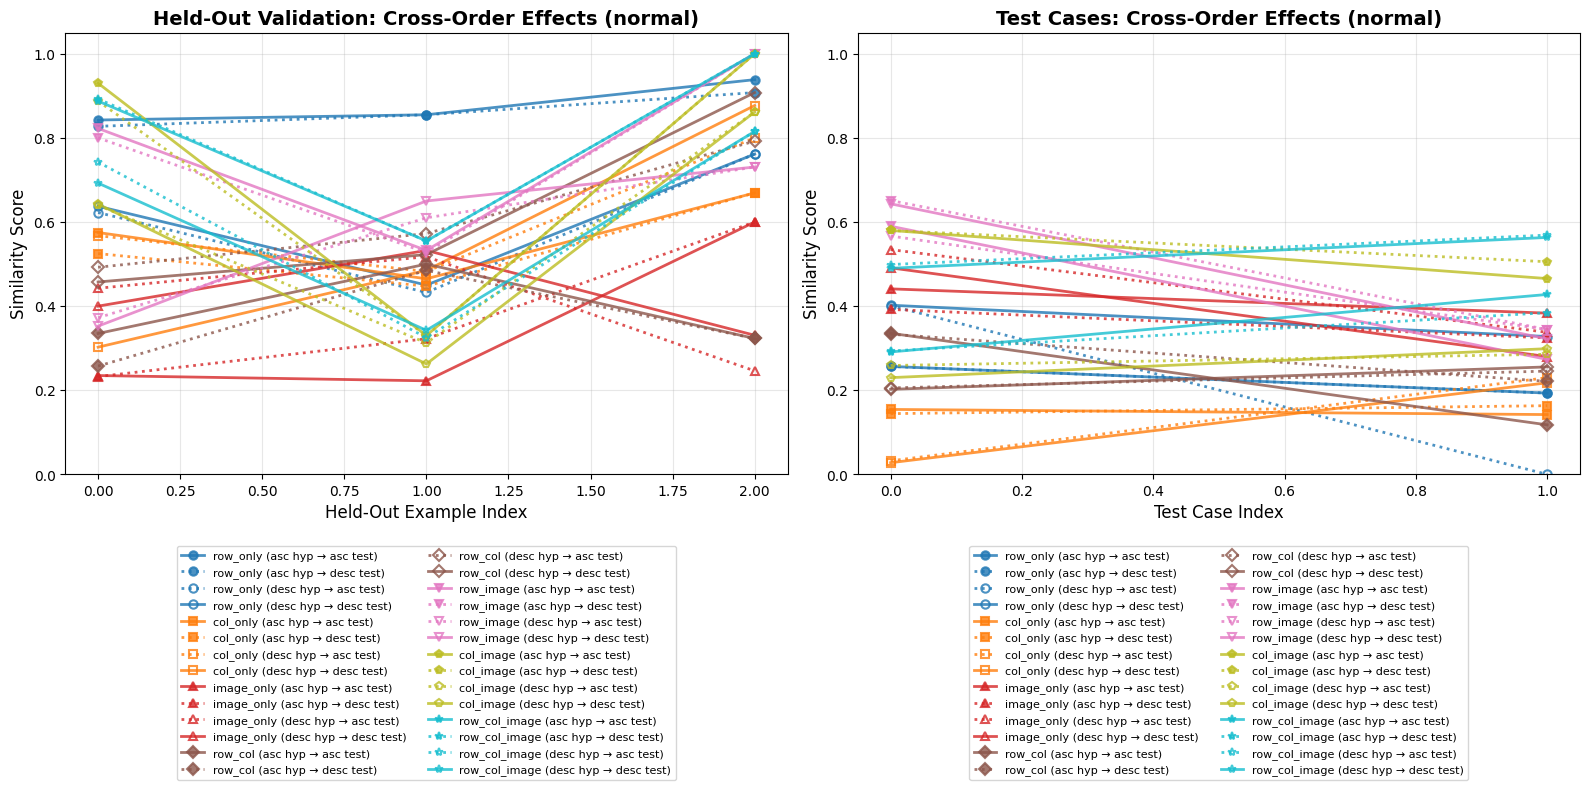

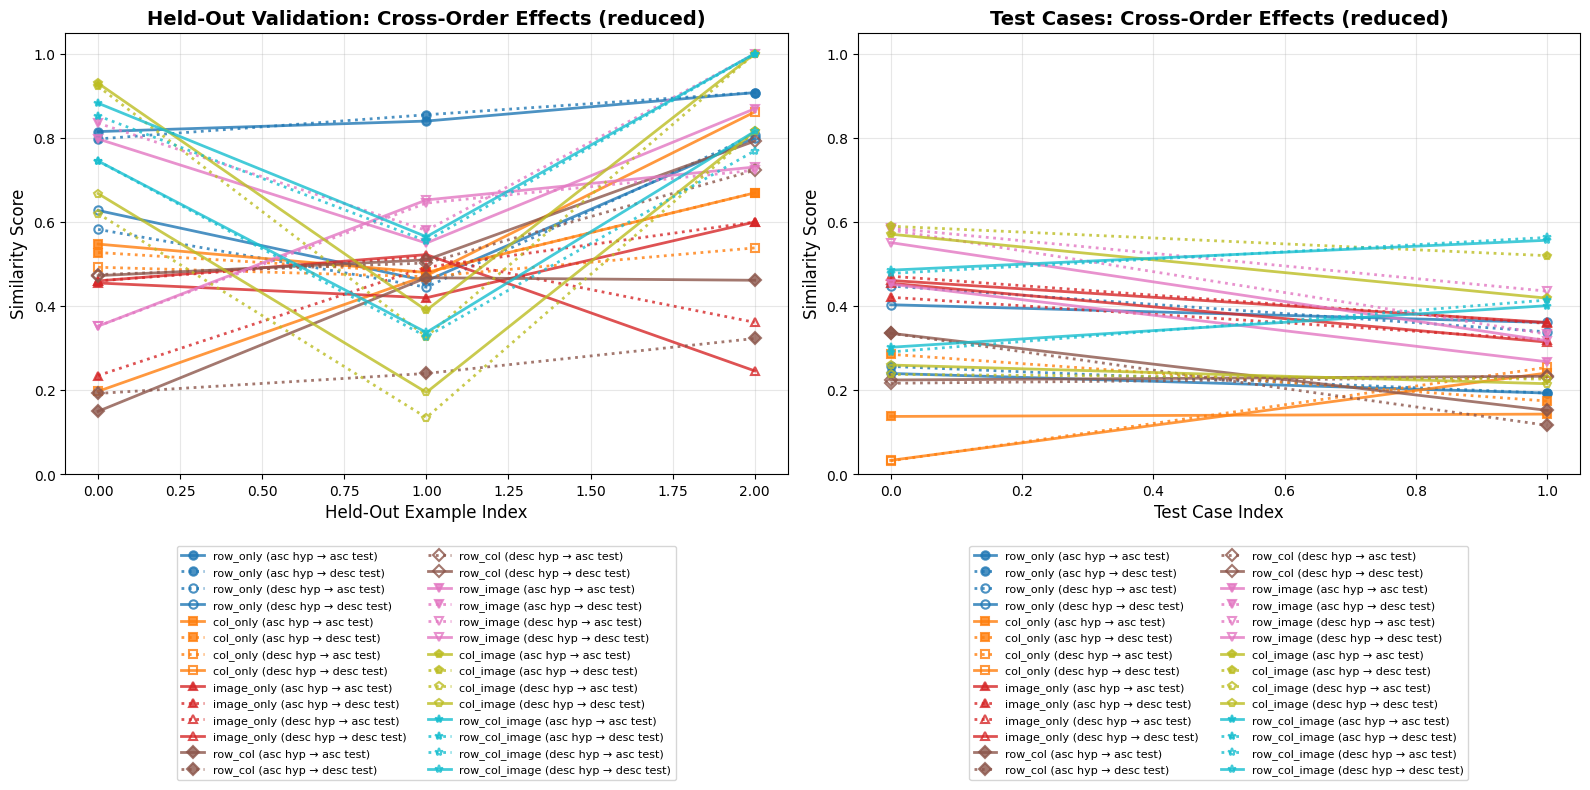

In [7]:
# Create cross-order plots
print("Creating cross-order plots...")
fig_normal = create_cross_order_plot(cross_order_data, variant="normal", save=True)
fig_reduced = create_cross_order_plot(cross_order_data, variant="reduced", save=True)
plt.show()


Creating combined scatter plot...
✓ Saved scatter plot: /home/bwen/projects/arc-aif-agi/modality_experiment_results/13e47133/20251105_1142/plots/cross_order_scatter_combined.png


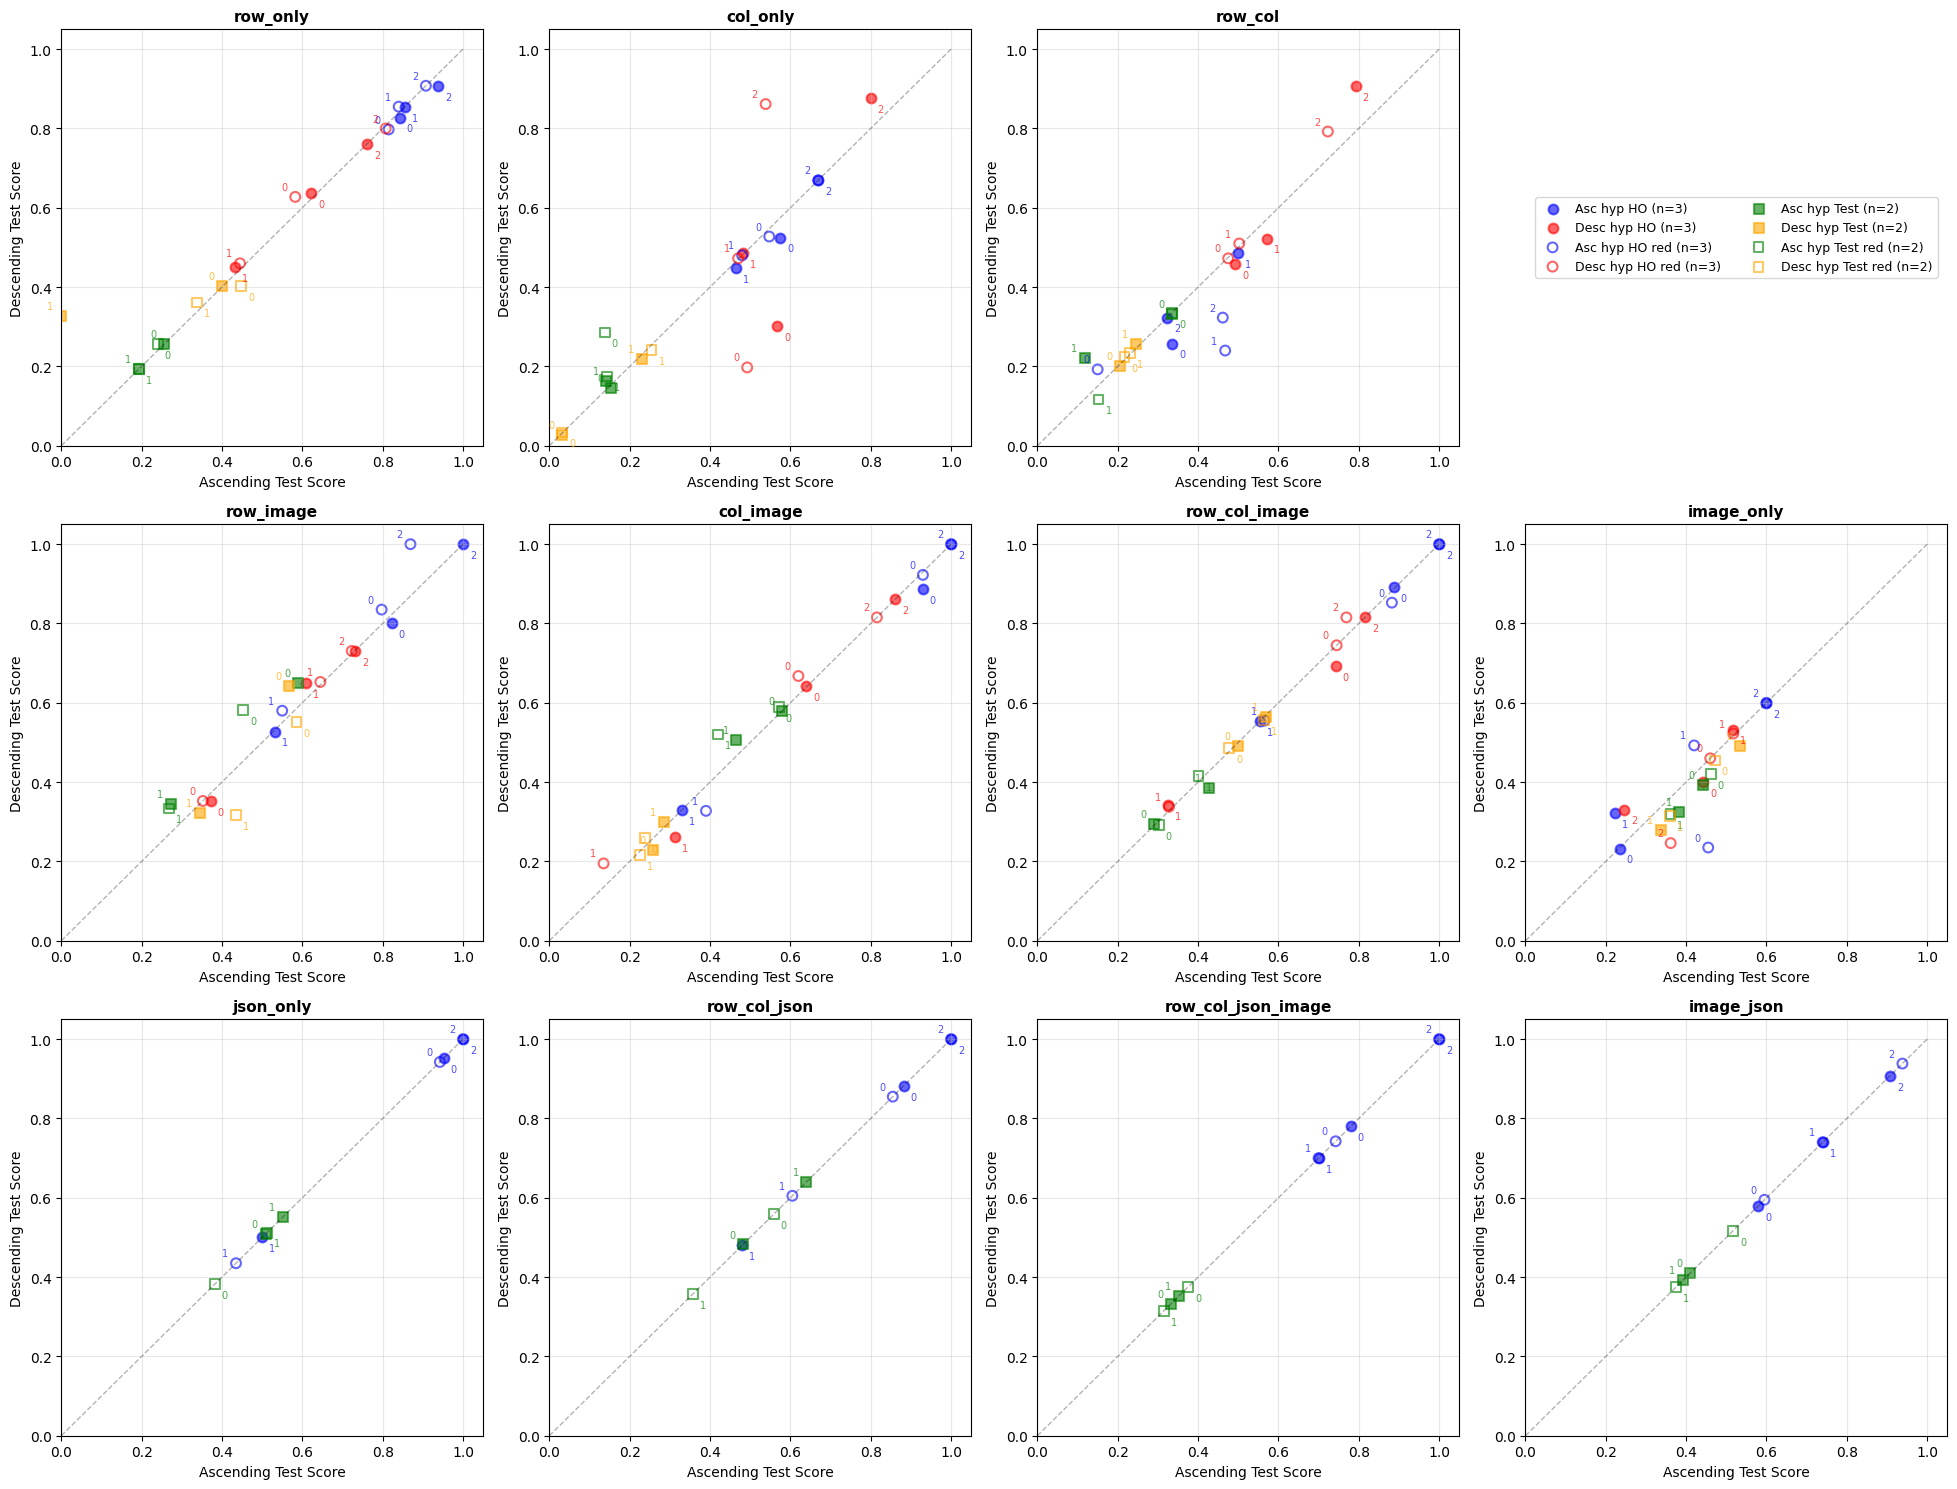

In [8]:
# Scatter plot function
def plot_modality_scatter(ax, data, modality, show_legend=False):
    """
    Helper function to plot a single modality on the given axis.
    """
    # Plot held-out normal (solid circles)
    ho_normal = data.get("held_out", [])
    if ho_normal:
        asc_hyp_results = [r for r in ho_normal if r["hypothesis_order"] == "ascending"]
        desc_hyp_results = [r for r in ho_normal if r["hypothesis_order"] == "descending"]
        
        if asc_hyp_results:
            asc_scores = [r["asc_score"] for r in asc_hyp_results]
            desc_scores = [r["desc_score"] for r in asc_hyp_results]
            labels = [r.get("held_out_idx", "") for r in asc_hyp_results]
            ax.scatter(asc_scores, desc_scores, alpha=0.6, s=50, color='blue', 
                      label=f"Asc hyp HO (n={len(asc_scores)})", marker='o', 
                      facecolors='blue', edgecolors='blue', linewidths=1.5)
            for x, y, label in zip(asc_scores, desc_scores, labels):
                if label is not None:
                    ax.annotate(str(label), (x, y), xytext=(5, -10), textcoords='offset points',
                                fontsize=7, alpha=0.7, color='blue')
        
        if desc_hyp_results:
            asc_scores = [r["asc_score"] for r in desc_hyp_results]
            desc_scores = [r["desc_score"] for r in desc_hyp_results]
            labels = [r.get("held_out_idx", "") for r in desc_hyp_results]
            ax.scatter(asc_scores, desc_scores, alpha=0.6, s=50, color='red',
                      label=f"Desc hyp HO (n={len(desc_scores)})", marker='o',
                      facecolors='red', edgecolors='red', linewidths=1.5)
            for x, y, label in zip(asc_scores, desc_scores, labels):
                if label is not None:
                    ax.annotate(str(label), (x, y), xytext=(5, -10), textcoords='offset points',
                                fontsize=7, alpha=0.7, color='red')
    
    # Plot held-out reduced (open circles)
    ho_reduced = data.get("held_out_reduced", [])
    if ho_reduced:
        asc_hyp_results = [r for r in ho_reduced if r["hypothesis_order"] == "ascending"]
        desc_hyp_results = [r for r in ho_reduced if r["hypothesis_order"] == "descending"]
        
        if asc_hyp_results:
            asc_scores = [r["asc_score"] for r in asc_hyp_results]
            desc_scores = [r["desc_score"] for r in asc_hyp_results]
            labels = [r.get("held_out_idx", "") for r in asc_hyp_results]
            ax.scatter(asc_scores, desc_scores, alpha=0.6, s=50, color='blue',
                      label=f"Asc hyp HO red (n={len(asc_scores)})", marker='o',
                      facecolors='none', edgecolors='blue', linewidths=1.5)
            for x, y, label in zip(asc_scores, desc_scores, labels):
                if label is not None:
                    ax.annotate(str(label), (x, y), xytext=(-10, 5), textcoords='offset points',
                                fontsize=7, alpha=0.7, color='blue', style='italic')
        
        if desc_hyp_results:
            asc_scores = [r["asc_score"] for r in desc_hyp_results]
            desc_scores = [r["desc_score"] for r in desc_hyp_results]
            labels = [r.get("held_out_idx", "") for r in desc_hyp_results]
            ax.scatter(asc_scores, desc_scores, alpha=0.6, s=50, color='red',
                      label=f"Desc hyp HO red (n={len(desc_scores)})", marker='o',
                      facecolors='none', edgecolors='red', linewidths=1.5)
            for x, y, label in zip(asc_scores, desc_scores, labels):
                if label is not None:
                    ax.annotate(str(label), (x, y), xytext=(-10, 5), textcoords='offset points',
                                fontsize=7, alpha=0.7, color='red', style='italic')
    
    # Plot test normal (solid squares)
    test_normal = data.get("test", [])
    if test_normal:
        asc_hyp_results = [r for r in test_normal if r["hypothesis_order"] == "ascending"]
        desc_hyp_results = [r for r in test_normal if r["hypothesis_order"] == "descending"]
        
        if asc_hyp_results:
            asc_scores = [r["asc_score"] for r in asc_hyp_results]
            desc_scores = [r["desc_score"] for r in asc_hyp_results]
            labels = [r.get("test_idx", "") for r in asc_hyp_results]
            ax.scatter(asc_scores, desc_scores, alpha=0.6, s=50, color='green',
                      label=f"Asc hyp Test (n={len(asc_scores)})", marker='s',
                      facecolors='green', edgecolors='green', linewidths=1.5)
            for x, y, label in zip(asc_scores, desc_scores, labels):
                if label is not None:
                    ax.annotate(str(label), (x, y), xytext=(-10, 5), textcoords='offset points',
                                fontsize=7, alpha=0.7, color='green')
        
        if desc_hyp_results:
            asc_scores = [r["asc_score"] for r in desc_hyp_results]
            desc_scores = [r["desc_score"] for r in desc_hyp_results]
            labels = [r.get("test_idx", "") for r in desc_hyp_results]
            ax.scatter(asc_scores, desc_scores, alpha=0.6, s=50, color='orange',
                      label=f"Desc hyp Test (n={len(desc_scores)})", marker='s',
                      facecolors='orange', edgecolors='orange', linewidths=1.5)
            for x, y, label in zip(asc_scores, desc_scores, labels):
                if label is not None:
                    ax.annotate(str(label), (x, y), xytext=(-10, 5), textcoords='offset points',
                                fontsize=7, alpha=0.7, color='orange')
    
    # Plot test reduced (open squares)
    test_reduced = data.get("test_reduced", [])
    if test_reduced:
        asc_hyp_results = [r for r in test_reduced if r["hypothesis_order"] == "ascending"]
        desc_hyp_results = [r for r in test_reduced if r["hypothesis_order"] == "descending"]
        
        if asc_hyp_results:
            asc_scores = [r["asc_score"] for r in asc_hyp_results]
            desc_scores = [r["desc_score"] for r in asc_hyp_results]
            labels = [r.get("test_idx", "") for r in asc_hyp_results]
            ax.scatter(asc_scores, desc_scores, alpha=0.6, s=50, color='green',
                      label=f"Asc hyp Test red (n={len(asc_scores)})", marker='s',
                      facecolors='none', edgecolors='green', linewidths=1.5)
            for x, y, label in zip(asc_scores, desc_scores, labels):
                if label is not None:
                    ax.annotate(str(label), (x, y), xytext=(5, -10), textcoords='offset points',
                                fontsize=7, alpha=0.7, color='green', style='italic')
        
        if desc_hyp_results:
            asc_scores = [r["asc_score"] for r in desc_hyp_results]
            desc_scores = [r["desc_score"] for r in desc_hyp_results]
            labels = [r.get("test_idx", "") for r in desc_hyp_results]
            ax.scatter(asc_scores, desc_scores, alpha=0.6, s=50, color='orange',
                      label=f"Desc hyp Test red (n={len(desc_scores)})", marker='s',
                      facecolors='none', edgecolors='orange', linewidths=1.5)
            for x, y, label in zip(asc_scores, desc_scores, labels):
                if label is not None:
                    ax.annotate(str(label), (x, y), xytext=(5, -10), textcoords='offset points',
                                fontsize=7, alpha=0.7, color='orange', style='italic')
    
    # Add diagonal line
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, linewidth=1)
    ax.set_xlabel("Ascending Test Score", fontsize=10)
    ax.set_ylabel("Descending Test Score", fontsize=10)
    ax.set_title(f"{modality}", fontsize=11, fontweight='bold')
    ax.set_xlim([0, 1.05])
    ax.set_ylim([0, 1.05])
    ax.grid(True, alpha=0.3)
    
    if show_legend:
        ax.legend(loc='center', fontsize=8, ncol=2, frameon=True)
    else:
        ax.legend().set_visible(False)

def create_scatter_plot(
    cross_order_data: Dict[str, Dict[str, List[Dict[str, Any]]]],
    save: bool = True
):
    """
    Create scatter plot: x=ascending test score, y=descending test score.
    Points closer to diagonal line indicate less cross-order effect.
    Combines normal (solid) and reduced (open) variants, and merges held-out and test cases.
    Arranges plots in 3x4 grid:
    Row 1: row_only, col_only, row_col, (Legends)
    Row 2: row_image, col_image, row_col_image, image_only
    Row 3: json_only, row_col_json, row_col_json_image, image_json
    """
    # Define the order
    modality_order = [
        ["row_only", "col_only", "row_col", None],  # Row 1: last is legend
        ["row_image", "col_image", "row_col_image", "image_only"],  # Row 2
        ["json_only", "row_col_json", "row_col_json_image", "image_json"]  # Row 3: new JSON modalities
    ]
    
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    
    # Plot each modality in the specified order
    for row_idx, row_modalities in enumerate(modality_order):
        for col_idx, modality in enumerate(row_modalities):
            if modality is None:
                # This is the legend position - get handles and labels from first plot
                ax = axes[row_idx, col_idx]
                ax.axis('off')
                # Get handles and labels from the first plot
                if row_idx == 0 and col_idx == 3:
                    # Get legend from first plot
                    first_ax = axes[0, 0]
                    # Re-plot invisible points to get handles
                    handles, labels = first_ax.get_legend_handles_labels()
                    if handles:
                        ax.legend(handles, labels, loc='center', fontsize=9, ncol=2, frameon=True)
            else:
                if modality in cross_order_data:
                    data = cross_order_data[modality]
                    ax = axes[row_idx, col_idx]
                    show_legend = (row_idx == 0 and col_idx == 3)
                    plot_modality_scatter(ax, data, modality, show_legend=False)
                else:
                    axes[row_idx, col_idx].axis('off')
    
    # Add shared legend in the first row, last column
    ax_legend = axes[0, 3]
    ax_legend.axis('off')
    # Get handles and labels from any plot (they're all the same)
    first_ax = axes[0, 0]
    handles, labels = first_ax.get_legend_handles_labels()
    if handles:
        ax_legend.legend(handles, labels, loc='center', fontsize=9, ncol=2, frameon=True)
    
    plt.tight_layout()
    
    if save:
        filename = "cross_order_scatter_combined.png"
        filepath = PLOTS_DIR / filename
        plt.savefig(filepath, dpi=150, bbox_inches='tight')
        print(f"✓ Saved scatter plot: {filepath}")
    
    return fig

# Create combined scatter plot
print("Creating combined scatter plot...")
fig_scatter = create_scatter_plot(cross_order_data, save=True)
plt.show()


## 5. Additional Investigations

Use the cells below to explore the data further. The following variables are available:
- `results`: Raw experiment results
- `cross_order_data`: Extracted cross-order data structure
- `stats_df`: DataFrame with computed statistics
- `summary`: Full summary dictionary with metadata


In [9]:
# Example: Filter statistics by modality
# stats_df[stats_df['modality'] == 'row_only']


In [10]:
# Example: Compare normal vs reduced context
# Compare stats for a specific modality
# modality = 'row_col'
# normal_stats = stats_df[(stats_df['modality'] == modality) & (stats_df['variant'] == 'held_out')]
# reduced_stats = stats_df[(stats_df['modality'] == modality) & (stats_df['variant'] == 'held_out_reduced')]
# print("Normal context:")
# print(normal_stats[['hypothesis_order', 'mean_diff', 'std_diff']])
# print("\nReduced context:")
# print(reduced_stats[['hypothesis_order', 'mean_diff', 'std_diff']])


In [11]:
# Example: Create custom visualization
# You can access the raw data for any modality:
# modality = 'image_only'
# variant = 'held_out_reduced'
# data = cross_order_data[modality][variant]
# print(f"Data for {modality} ({variant}):")
# for item in data:
#     print(f"  Hypothesis order: {item['hypothesis_order']}, "
#           f"Asc score: {item['asc_score']:.3f}, "
#           f"Desc score: {item['desc_score']:.3f}, "
#           f"Diff: {item['asc_score'] - item['desc_score']:.3f}")


## 6. Compare 1x1 vs 2x2 Experiments

Compare the 1x1 experiment (20251105_1142) with the 2x2 experiment (20251107_1653) to see the impact of using 2x2 grids.


In [12]:
# Load 2x2 experiment results (20251107_1653)
RESULTS_DIR_2x2 = NOTEBOOK_DIR.parent / "20251107_1653"
RESULTS_FILE_2x2 = RESULTS_DIR_2x2 / "results.json"

if RESULTS_FILE_2x2.exists():
    summary_2x2 = load_results(RESULTS_FILE_2x2)
    results_2x2 = summary_2x2.get("results", [])
    print(f"Loaded 2x2 experiment:")
    print(f"  Session ID: {summary_2x2.get('session_id', 'N/A')}")
    print(f"  Results: {len(results_2x2)}")
else:
    print(f"Warning: 2x2 results file not found: {RESULTS_FILE_2x2}")
    results_2x2 = []
    summary_2x2 = {}

# Extract scores from both experiments in a comparable format
def extract_scores_for_comparison(results: List[Dict[str, Any]]) -> Dict[str, Dict[str, Dict[str, Dict[int, float]]]]:
    """
    Extract scores organized by:
    {
        modality: {
            order: {
                variant: {
                    idx: score  # For held_out: held_out_idx -> best_similarity
                                 # For test: test_idx -> best_similarity (ascending or descending)
                }
            }
        }
    }
    """
    scores = {}
    
    for result in results:
        if "error" in result:
            continue
        
        modality = result["modality_type"]
        order = result["example_order"]
        
        if modality not in scores:
            scores[modality] = {}
        if order not in scores[modality]:
            scores[modality][order] = {
                "held_out": {},
                "test_asc": {},
                "test_desc": {},
                "held_out_reduced": {},
                "test_asc_reduced": {},
                "test_desc_reduced": {}
            }
        
        # Extract held-out scores (normal)
        for ho_result in result.get("held_out_results", []):
            if "error" not in ho_result:
                idx = ho_result.get("held_out_idx")
                score = ho_result.get("best_similarity", 0.0)
                scores[modality][order]["held_out"][idx] = score
        
        # Extract test scores (normal) - separate by test order
        for test_result in result.get("test_results", []):
            if "error" not in test_result:
                idx = test_result.get("test_idx")
                asc_score = test_result.get("ascending", {}).get("similarity", 0.0)
                desc_score = test_result.get("descending", {}).get("similarity", 0.0)
                scores[modality][order]["test_asc"][idx] = asc_score
                scores[modality][order]["test_desc"][idx] = desc_score
        
        # Extract held-out scores (reduced)
        for ho_result in result.get("held_out_results_reduced", []):
            if "error" not in ho_result:
                idx = ho_result.get("held_out_idx")
                score = ho_result.get("best_similarity", 0.0)
                scores[modality][order]["held_out_reduced"][idx] = score
        
        # Extract test scores (reduced) - separate by test order
        for test_result in result.get("test_results_reduced", []):
            if "error" not in test_result:
                idx = test_result.get("test_idx")
                asc_score = test_result.get("ascending", {}).get("similarity", 0.0)
                desc_score = test_result.get("descending", {}).get("similarity", 0.0)
                scores[modality][order]["test_asc_reduced"][idx] = asc_score
                scores[modality][order]["test_desc_reduced"][idx] = desc_score
    
    return scores

# Extract scores from both experiments
scores_1x1 = extract_scores_for_comparison(results)
scores_2x2 = extract_scores_for_comparison(results_2x2)

print(f"\nExtracted scores:")
print(f"  1x1 experiment: {len(scores_1x1)} modalities")
print(f"  2x2 experiment: {len(scores_2x2)} modalities")


Loaded 2x2 experiment:
  Session ID: 13e47133-modality_experiment-20251107_1653
  Results: 14

Extracted scores:
  1x1 experiment: 7 modalities
  2x2 experiment: 7 modalities


In [13]:
# Calculate differences: 2x2_score - 1x1_score
def calculate_differences(
    scores_1x1: Dict[str, Dict[str, Dict[str, Dict[int, float]]]],
    scores_2x2: Dict[str, Dict[str, Dict[str, Dict[int, float]]]]
) -> Dict[str, Dict[str, Dict[str, List[float]]]]:
    """
    Calculate differences for matching conditions.
    Returns:
    {
        modality: {
            order: {
                variant: [diff1, diff2, ...]  # List of differences for matching indices
            }
        }
    }
    """
    differences = {}
    
    # Get all modalities present in both experiments
    all_modalities = set(scores_1x1.keys()) & set(scores_2x2.keys())
    
    for modality in all_modalities:
        differences[modality] = {}
        
        # Get all orders present in both experiments
        orders_1x1 = set(scores_1x1[modality].keys())
        orders_2x2 = set(scores_2x2[modality].keys())
        all_orders = orders_1x1 & orders_2x2
        
        for order in all_orders:
            differences[modality][order] = {}
            
            variants = [
                "held_out",
                "test_asc",
                "test_desc",
                "held_out_reduced",
                "test_asc_reduced",
                "test_desc_reduced"
            ]
            
            for variant in variants:
                diffs = []
                
                # Get matching indices
                idxs_1x1 = set(scores_1x1[modality][order][variant].keys())
                idxs_2x2 = set(scores_2x2[modality][order][variant].keys())
                matching_idxs = idxs_1x1 & idxs_2x2
                
                for idx in sorted(matching_idxs):
                    score_1x1 = scores_1x1[modality][order][variant][idx]
                    score_2x2 = scores_2x2[modality][order][variant][idx]
                    diff = score_2x2 - score_1x1
                    diffs.append(diff)
                
                differences[modality][order][variant] = diffs
    
    return differences

# Calculate differences
diffs = calculate_differences(scores_1x1, scores_2x2)

# Print summary
print("Difference summary (2x2 - 1x1):")
for modality in sorted(diffs.keys()):
    print(f"\n  {modality}:")
    for order in sorted(diffs[modality].keys()):
        for variant, diff_list in diffs[modality][order].items():
            if diff_list:
                mean_diff = np.mean(diff_list)
                print(f"    {order} {variant}: mean={mean_diff:.4f}, n={len(diff_list)}")


Difference summary (2x2 - 1x1):

  col_image:
    ascending held_out: mean=-0.0837, n=3
    ascending test_asc: mean=-0.5228, n=2
    ascending test_desc: mean=-0.5428, n=2
    ascending held_out_reduced: mean=-0.1045, n=3
    ascending test_asc_reduced: mean=-0.4950, n=2
    ascending test_desc_reduced: mean=-0.5550, n=2
    descending held_out: mean=0.1594, n=3
    descending test_asc: mean=-0.2722, n=2
    descending test_desc: mean=-0.2644, n=2
    descending held_out_reduced: mean=0.1971, n=3
    descending test_asc_reduced: mean=-0.2322, n=2
    descending test_desc_reduced: mean=-0.2378, n=2

  col_only:
    ascending held_out: mean=0.1825, n=2
    ascending test_asc: mean=-0.1483, n=2
    ascending test_desc: mean=-0.1539, n=2
    ascending held_out_reduced: mean=0.1888, n=2
    ascending test_asc_reduced: mean=-0.1406, n=2
    ascending test_desc_reduced: mean=-0.2300, n=2
    descending held_out: mean=0.0466, n=3
    descending test_asc: mean=-0.1311, n=2
    descending test_


Creating difference plot...
✓ Saved difference plot: /home/bwen/projects/arc-aif-agi/modality_experiment_results/13e47133/20251105_1142/plots/modality_difference_2x2_vs_1x1.png


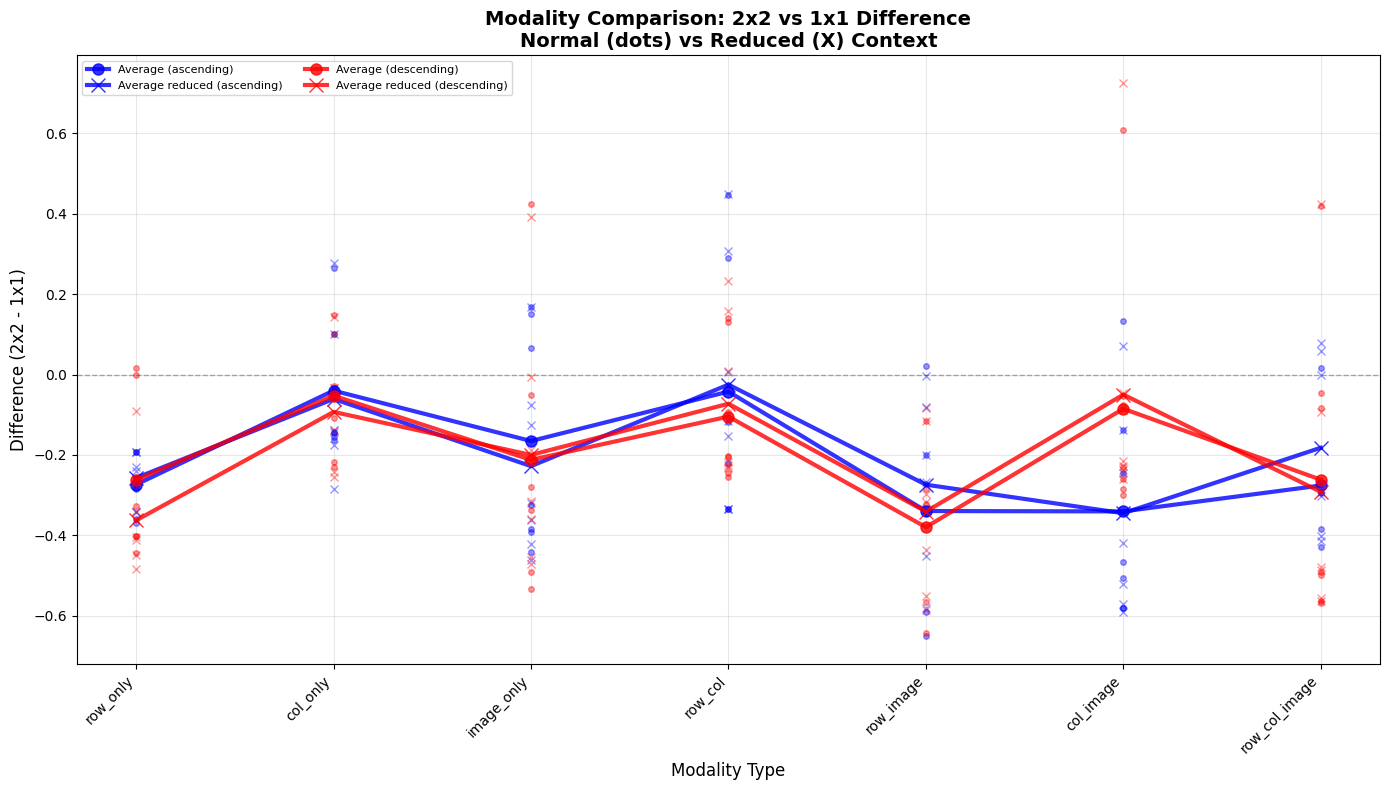

In [14]:
# Create difference plot similar to modality_comparison.png
def create_difference_plot(
    differences: Dict[str, Dict[str, Dict[str, List[float]]]],
    save: bool = True
):
    """
    Plot differences (2x2 - 1x1) as a function of modality type.
    Similar style to modality_comparison.png.
    """
    # Filter to available modalities (only those in MODALITY_TYPES)
    available_modalities = [m for m in MODALITY_TYPES if m in differences]
    
    if not available_modalities:
        print("No matching modalities found for comparison")
        return None
    
    modality_positions = {mod: i for i, mod in enumerate(available_modalities)}
    
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Collect all differences by modality, order, and variant
    # Structure: (modality, order, variant) -> list of differences
    diff_data = {}
    
    for modality in available_modalities:
        for order in differences[modality].keys():
            for variant, diff_list in differences[modality][order].items():
                if diff_list:
                    key = (modality, order, variant)
                    diff_data[key] = diff_list
    
    # Plot individual differences (thin lines) for each held-out/test case
    # Group by: order (asc/desc) and variant (normal/reduced)
    
    # Colors for orders
    order_colors = {
        "ascending": "blue",
        "descending": "red"
    }
    
    # Plot individual differences for normal context
    for order in ["ascending", "descending"]:
        color = order_colors[order]
        
        # Held-out normal
        for modality in available_modalities:
            key = (modality, order, "held_out")
            if key in diff_data:
                diffs = diff_data[key]
                if diffs:
                    x_pos = modality_positions[modality]
                    for i, diff in enumerate(diffs):
                        ax.plot(
                            [x_pos], [diff],
                            color=color, marker='o', markersize=4,
                            alpha=0.4, linewidth=0.5
                        )
        
        # Test ascending normal
        for modality in available_modalities:
            key = (modality, order, "test_asc")
            if key in diff_data:
                diffs = diff_data[key]
                if diffs:
                    x_pos = modality_positions[modality]
                    for i, diff in enumerate(diffs):
                        ax.plot(
                            [x_pos], [diff],
                            color=color, marker='o', markersize=4,
                            alpha=0.4, linewidth=0.5
                        )
        
        # Test descending normal
        for modality in available_modalities:
            key = (modality, order, "test_desc")
            if key in diff_data:
                diffs = diff_data[key]
                if diffs:
                    x_pos = modality_positions[modality]
                    for i, diff in enumerate(diffs):
                        ax.plot(
                            [x_pos], [diff],
                            color=color, marker='o', markersize=4,
                            alpha=0.4, linewidth=0.5
                        )
    
    # Plot individual differences for reduced context (X markers)
    for order in ["ascending", "descending"]:
        color = order_colors[order]
        
        # Held-out reduced
        for modality in available_modalities:
            key = (modality, order, "held_out_reduced")
            if key in diff_data:
                diffs = diff_data[key]
                if diffs:
                    x_pos = modality_positions[modality]
                    for i, diff in enumerate(diffs):
                        ax.plot(
                            [x_pos], [diff],
                            color=color, marker='x', markersize=6,
                            alpha=0.4, linewidth=0.5
                        )
        
        # Test ascending reduced
        for modality in available_modalities:
            key = (modality, order, "test_asc_reduced")
            if key in diff_data:
                diffs = diff_data[key]
                if diffs:
                    x_pos = modality_positions[modality]
                    for i, diff in enumerate(diffs):
                        ax.plot(
                            [x_pos], [diff],
                            color=color, marker='x', markersize=6,
                            alpha=0.4, linewidth=0.5
                        )
        
        # Test descending reduced
        for modality in available_modalities:
            key = (modality, order, "test_desc_reduced")
            if key in diff_data:
                diffs = diff_data[key]
                if diffs:
                    x_pos = modality_positions[modality]
                    for i, diff in enumerate(diffs):
                        ax.plot(
                            [x_pos], [diff],
                            color=color, marker='x', markersize=6,
                            alpha=0.4, linewidth=0.5
                        )
    
    # Plot average lines (thick lines)
    for order in ["ascending", "descending"]:
        color = order_colors[order]
        
        # Average for normal context (dots)
        avg_scores_normal = []
        for modality in available_modalities:
            all_diffs_normal = []
            for variant in ["held_out", "test_asc", "test_desc"]:
                key = (modality, order, variant)
                if key in diff_data:
                    all_diffs_normal.extend(diff_data[key])
            if all_diffs_normal:
                avg_scores_normal.append(np.mean(all_diffs_normal))
            else:
                avg_scores_normal.append(None)
        
        if any(s is not None for s in avg_scores_normal):
            ax.plot(
                [modality_positions[m] for m in available_modalities],
                avg_scores_normal,
                color=color,
                linewidth=3,
                marker='o',
                markersize=8,
                label=f"Average ({order})",
                alpha=0.8
            )
        
        # Average for reduced context (X)
        avg_scores_reduced = []
        for modality in available_modalities:
            all_diffs_reduced = []
            for variant in ["held_out_reduced", "test_asc_reduced", "test_desc_reduced"]:
                key = (modality, order, variant)
                if key in diff_data:
                    all_diffs_reduced.extend(diff_data[key])
            if all_diffs_reduced:
                avg_scores_reduced.append(np.mean(all_diffs_reduced))
            else:
                avg_scores_reduced.append(None)
        
        if any(s is not None for s in avg_scores_reduced):
            ax.plot(
                [modality_positions[m] for m in available_modalities],
                avg_scores_reduced,
                color=color,
                linewidth=3,
                marker='x',
                markersize=10,
                label=f"Average reduced ({order})",
                alpha=0.8
            )
    
    # Add horizontal line at y=0
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.3)
    
    ax.set_xlabel("Modality Type", fontsize=12)
    ax.set_ylabel("Difference (2x2 - 1x1)", fontsize=12)
    ax.set_title("Modality Comparison: 2x2 vs 1x1 Difference\nNormal (dots) vs Reduced (X) Context", fontsize=14, fontweight='bold')
    ax.set_xticks(range(len(available_modalities)))
    ax.set_xticklabels(available_modalities, rotation=45, ha='right')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=8, ncol=2)
    
    plt.tight_layout()
    
    if save:
        filename = "modality_difference_2x2_vs_1x1.png"
        filepath = PLOTS_DIR / filename
        plt.savefig(filepath, dpi=150, bbox_inches='tight')
        print(f"✓ Saved difference plot: {filepath}")
    
    return fig

# Create the difference plot
if results_2x2:
    print("\nCreating difference plot...")
    fig_diff = create_difference_plot(diffs, save=True)
    plt.show()
else:
    print("\nCannot create difference plot: 2x2 experiment data not available")



Creating modality score comparison plot...
✓ Saved score comparison plot: /home/bwen/projects/arc-aif-agi/modality_experiment_results/13e47133/20251105_1142/plots/modality_score_comparison.png


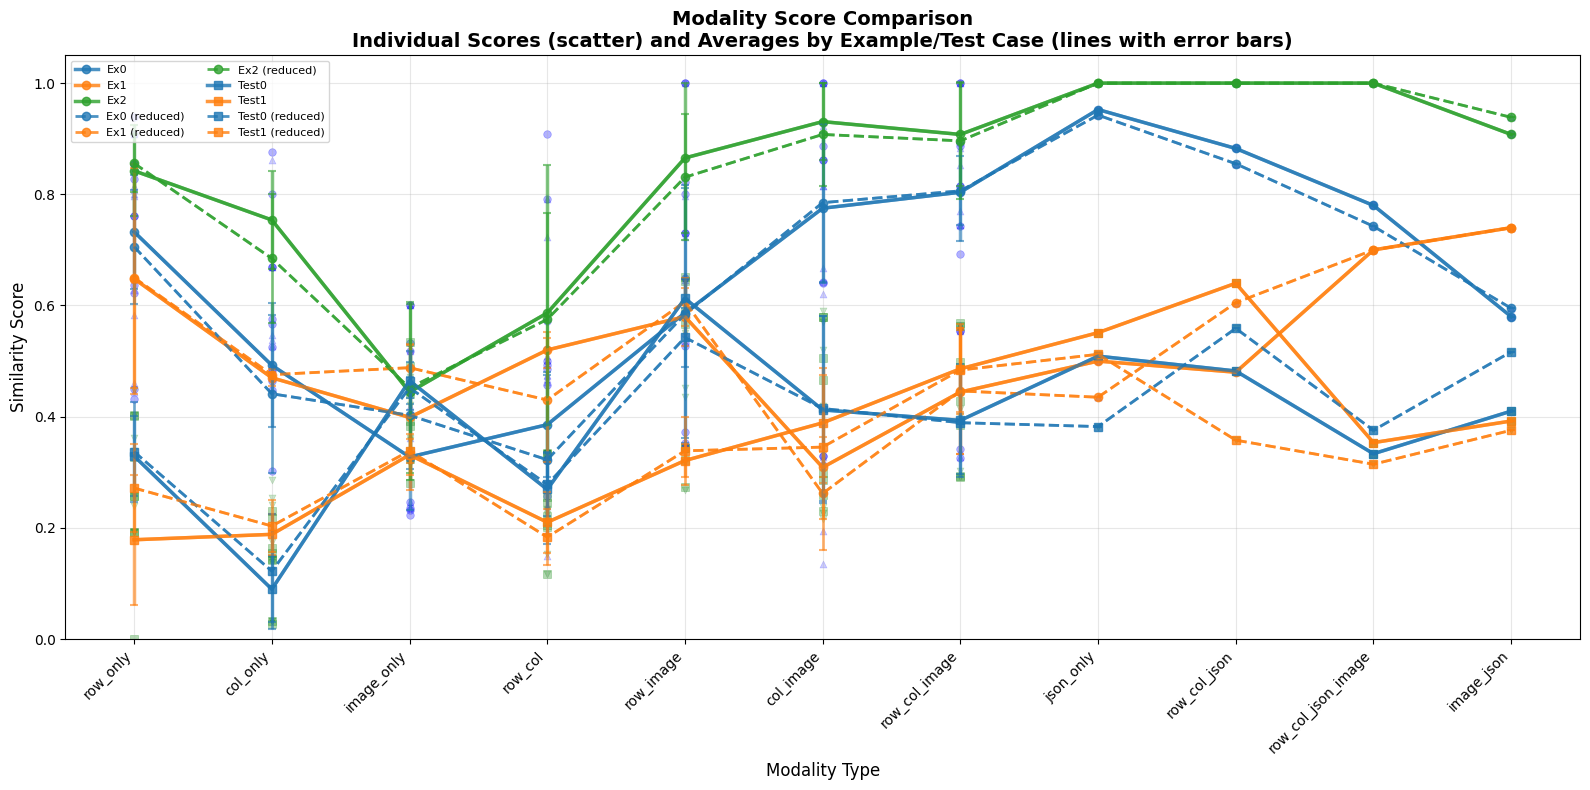

In [15]:
# Create modality score comparison plot
def create_modality_score_plot(
    cross_order_data: Dict[str, Dict[str, List[Dict[str, Any]]]],
    save: bool = True
):
    """
    Plot original scores (not differences) by modality.
    - X-axis: modalities
    - Y-axis: scores
    - Scatter points: all variations (orders, variants) with lighter colors
    - Average lines with error bars: separated by example/test cases (Ex0, Ex1, Ex2, Test0, Test1)
    """
    # Get all available modalities (combine MODALITY_TYPES and JSON_MODALITY_TYPES)
    all_modality_types = MODALITY_TYPES + JSON_MODALITY_TYPES
    available_modalities = [m for m in all_modality_types if m in cross_order_data]
    
    if not available_modalities:
        print("No modalities found in cross_order_data")
        return None
    
    modality_positions = {mod: i for i, mod in enumerate(available_modalities)}
    
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # Collect all scores organized by modality, example/test index, and variant
    # Structure: (modality, idx, variant_type) -> list of scores
    # variant_type: "held_out_asc", "held_out_desc", "test_asc", "test_desc", etc.
    score_data = {}
    
    for modality in available_modalities:
        data = cross_order_data[modality]
        
        # Process held_out (normal)
        for item in data.get("held_out", []):
            idx = item.get("held_out_idx")
            if idx is not None:
                key = (modality, idx, "held_out")
                if key not in score_data:
                    score_data[key] = []
                score_data[key].append(item["asc_score"])
                score_data[key].append(item["desc_score"])
        
        # Process test (normal)
        for item in data.get("test", []):
            idx = item.get("test_idx")
            if idx is not None:
                key = (modality, idx, "test")
                if key not in score_data:
                    score_data[key] = []
                score_data[key].append(item["asc_score"])
                score_data[key].append(item["desc_score"])
        
        # Process held_out_reduced
        for item in data.get("held_out_reduced", []):
            idx = item.get("held_out_idx")
            if idx is not None:
                key = (modality, idx, "held_out_reduced")
                if key not in score_data:
                    score_data[key] = []
                score_data[key].append(item["asc_score"])
                score_data[key].append(item["desc_score"])
        
        # Process test_reduced
        for item in data.get("test_reduced", []):
            idx = item.get("test_idx")
            if idx is not None:
                key = (modality, idx, "test_reduced")
                if key not in score_data:
                    score_data[key] = []
                score_data[key].append(item["asc_score"])
                score_data[key].append(item["desc_score"])
    
    # Plot scatter points for all individual scores
    # Use different markers and lighter colors for different variants
    variant_styles = {
        "held_out": {"marker": "o", "color": "blue", "alpha": 0.3, "size": 30},
        "test": {"marker": "s", "color": "green", "alpha": 0.3, "size": 30},
        "held_out_reduced": {"marker": "^", "color": "blue", "alpha": 0.2, "size": 25},
        "test_reduced": {"marker": "v", "color": "green", "alpha": 0.2, "size": 25},
    }
    
    for (modality, idx, variant_type), scores in score_data.items():
        if not scores:
            continue
        
        # Get style - check full variant_type first, then base variant
        style = variant_styles.get(variant_type)
        if style is None:
            base_variant = variant_type.replace("_reduced", "")
            style = variant_styles.get(base_variant, {"marker": "o", "color": "gray", "alpha": 0.3, "size": 30})
        
        x_pos = modality_positions[modality]
        for score in scores:
            ax.scatter(
                x_pos, score,
                marker=style["marker"],
                color=style["color"],
                alpha=style["alpha"],
                s=style["size"],
                edgecolors=style["color"],
                linewidths=0.5
            )
    
    # Calculate and plot average lines with error bars, separated by example/test index
    # Group by: (modality, idx, variant_type) -> mean and std
    avg_data = {}
    
    for (modality, idx, variant_type), scores in score_data.items():
        if scores:
            key = (modality, idx, variant_type)
            avg_data[key] = {
                "mean": np.mean(scores),
                "std": np.std(scores),
                "n": len(scores)
            }
    
    # Plot average lines with error bars, one line per example/test case
    # Colors for different example/test indices
    idx_colors = plt.cm.tab10(np.linspace(0, 1, 10))
    
    # Find all unique indices and variant types
    all_indices = set()
    all_variant_types = set()
    for (modality, idx, variant_type) in avg_data.keys():
        all_indices.add(idx)
        all_variant_types.add(variant_type)
    
    all_indices = sorted(all_indices)
    all_variant_types = sorted(all_variant_types)
    
    # Plot one line per index/variant combination
    for variant_type in all_variant_types:
        base_variant = variant_type.replace("_reduced", "")
        is_reduced = "_reduced" in variant_type
        
        for idx in all_indices:
            # Collect means and stds for this index/variant across all modalities
            means = []
            stds = []
            modalities_with_data = []
            
            for modality in available_modalities:
                key = (modality, idx, variant_type)
                if key in avg_data:
                    means.append(avg_data[key]["mean"])
                    stds.append(avg_data[key]["std"])
                    modalities_with_data.append(modality)
                else:
                    means.append(None)
                    stds.append(None)
                    modalities_with_data.append(modality)
            
            # Only plot if we have data for at least one modality
            if any(m is not None for m in means):
                x_positions = [modality_positions[m] for m in modalities_with_data]
                valid_means = [m for m in means if m is not None]
                valid_stds = [s for m, s in zip(means, stds) if m is not None]
                valid_x = [x for x, m in zip(x_positions, means) if m is not None]
                
                if valid_means:
                    # Choose color based on index
                    color = idx_colors[idx % len(idx_colors)]
                    
                    # Choose linestyle based on reduced/normal
                    linestyle = "--" if is_reduced else "-"
                    linewidth = 2 if is_reduced else 2.5
                    
                    # Label
                    if base_variant == "held_out":
                        label = f"Ex{idx}" + (" (reduced)" if is_reduced else "")
                    else:
                        label = f"Test{idx}" + (" (reduced)" if is_reduced else "")
                    
                    # Plot line
                    ax.plot(
                        valid_x, valid_means,
                        color=color, linestyle=linestyle, linewidth=linewidth,
                        marker="o" if base_variant == "held_out" else "s",
                        markersize=6, alpha=0.8,
                        label=label
                    )
                    
                    # Plot error bars
                    ax.errorbar(
                        valid_x, valid_means, yerr=valid_stds,
                        color=color, linestyle=linestyle, linewidth=linewidth,
                        alpha=0.6, capsize=3, capthick=1.5
                    )
    
    ax.set_xlabel("Modality Type", fontsize=12)
    ax.set_ylabel("Similarity Score", fontsize=12)
    ax.set_title("Modality Score Comparison\nIndividual Scores (scatter) and Averages by Example/Test Case (lines with error bars)", 
                 fontsize=14, fontweight='bold')
    ax.set_xticks(range(len(available_modalities)))
    ax.set_xticklabels(available_modalities, rotation=45, ha='right')
    ax.set_ylim([0, 1.05])
    ax.grid(True, alpha=0.3)
    
    # Simplified legend - group by example/test and reduced/normal
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels, loc='upper left', fontsize=8, ncol=2, frameon=True, 
                 bbox_to_anchor=(0, 1))
    
    plt.tight_layout()
    
    if save:
        filename = "modality_score_comparison.png"
        filepath = PLOTS_DIR / filename
        plt.savefig(filepath, dpi=150, bbox_inches='tight')
        print(f"✓ Saved score comparison plot: {filepath}")
    
    return fig

# Create the score comparison plot
print("\nCreating modality score comparison plot...")
fig_score = create_modality_score_plot(cross_order_data, save=True)
plt.show()


In [16]:
# Example: Pivot table for easier comparison
# pivot = stats_df.pivot_table(
#     index=['modality', 'hypothesis_order'],
#     columns='variant',
#     values='mean_diff',
#     aggfunc='first'
# )
# print(pivot)


Creating modality violin plot (sorted by median)...
✓ Saved violin plot: /home/bwen/projects/arc-aif-agi/modality_experiment_results/13e47133/20251105_1142/plots/modality_score_distribution_violin_sorted.png


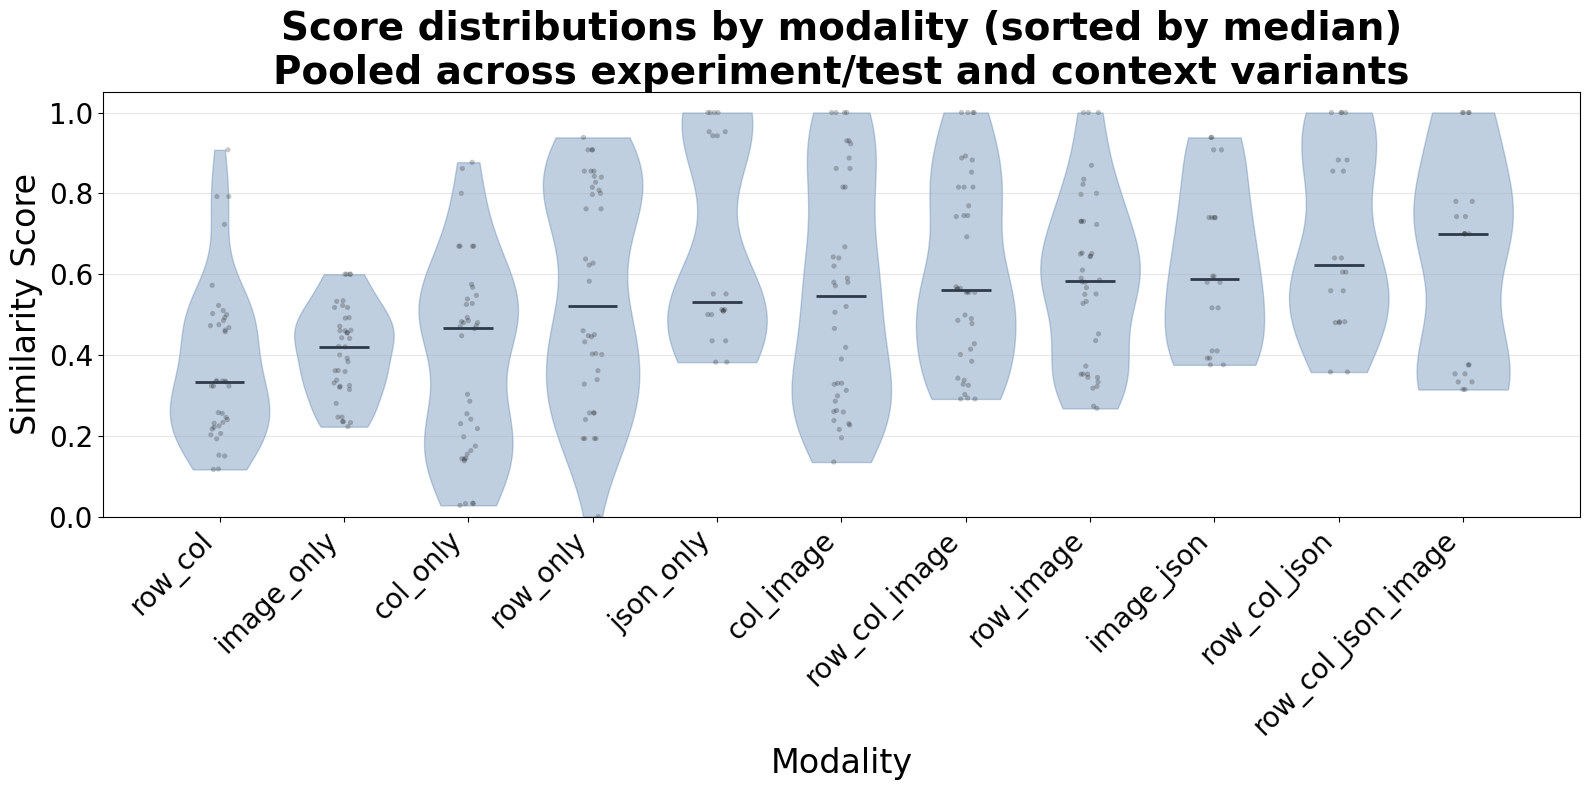

In [17]:
# Violin plot: score distributions by modality (pooled across variants)

def create_modality_violin_plot(
    cross_order_data: Dict[str, Dict[str, List[Dict[str, Any]]]],
    save: bool = True,
    order_by: str = "preset"  # one of {"preset", "median"}
):
    """
    Show distribution of original scores by modality, pooling across experiment/test and normal/reduced.
    - X-axis: modalities
    - Y-axis: similarity score
    - Visualization: violin per modality + jittered individual points
    - Optional ordering by median score
    """
    # Determine modalities available
    all_modality_types = MODALITY_TYPES + JSON_MODALITY_TYPES
    available_modalities = [m for m in all_modality_types if m in cross_order_data]
    if not available_modalities:
        print("No modalities found in cross_order_data")
        return None
    
    # Gather all scores per modality
    variant_keys = ["held_out", "test", "held_out_reduced", "test_reduced"]
    modality_to_scores: Dict[str, List[float]] = {m: [] for m in available_modalities}
    
    for modality in available_modalities:
        data = cross_order_data[modality]
        for key in variant_keys:
            for item in data.get(key, []) or []:
                asc = item.get("asc_score")
                desc = item.get("desc_score")
                if asc is not None:
                    modality_to_scores[modality].append(float(asc))
                if desc is not None:
                    modality_to_scores[modality].append(float(desc))
    
    # Remove modalities with no data
    modality_to_scores = {m: s for m, s in modality_to_scores.items() if len(s) > 0}
    if not modality_to_scores:
        print("No score data found to plot")
        return None
    
    # Optionally sort modalities by median score
    modalities = list(modality_to_scores.keys())
    if order_by == "median":
        modalities.sort(key=lambda m: np.median(modality_to_scores[m]))
    else:
        # keep preset order from MODALITY_TYPES + JSON_MODALITY_TYPES
        modalities = [m for m in available_modalities if m in modality_to_scores]
    
    # Prepare data in order
    data_in_order = [modality_to_scores[m] for m in modalities]
    positions = np.arange(len(modalities))
    
    # Plot
    fig, ax = plt.subplots(figsize=(16, 8))
    vp = ax.violinplot(
        data_in_order,
        positions=positions,
        widths=0.8,
        showmeans=False,
        showextrema=False,
        showmedians=True,
    )
    
    # Style violins
    violin_face = "#4C78A8"
    for body in vp["bodies"]:
        body.set_facecolor(violin_face)
        body.set_edgecolor(violin_face)
        body.set_alpha(0.35)
    if "cmedians" in vp:
        vp["cmedians"].set_color("#2F3A4A")
        vp["cmedians"].set_linewidth(2.0)
    
    # Overlay jittered individual points
    rng = np.random.default_rng(42)
    for i, scores in enumerate(data_in_order):
        if not scores:
            continue
        jitter = rng.uniform(-0.08, 0.08, size=len(scores))
        ax.scatter(
            np.full(len(scores), positions[i]) + jitter,
            scores,
            s=14,
            color="#000000",
            alpha=0.22,
            edgecolors="none",
        )
    
    # Axes formatting
    ax.set_xlabel("Modality", fontsize=24)
    ax.set_ylabel("Similarity Score", fontsize=24)
    title_order = " (sorted by median)" if order_by == "median" else ""
    
    ax.set_title(
        f"Score distributions by modality{title_order}\nPooled across experiment/test and context variants",
        fontsize=28,
        fontweight="bold",
    )
    
    # x tick labels
    xtick_labels = [m for m in modalities]
    ax.set_xticks(positions)
    ax.set_xticklabels(xtick_labels, rotation=45, ha="right", fontsize=20)
    ax.tick_params(axis="y", labelsize=20)
    ax.set_ylim([0, 1.05])
    ax.grid(True, axis="y", alpha=0.3)
    
    plt.tight_layout()
    
    if save:
        filename = "modality_score_distribution_violin.png" if order_by != "median" else "modality_score_distribution_violin_sorted.png"
        filepath = PLOTS_DIR / filename
        plt.savefig(filepath, dpi=150, bbox_inches="tight")
        print(f"✓ Saved violin plot: {filepath}")
    
    return fig

# # Create the violin plot (preset order)
# print("\nCreating modality violin plot (preset order)...")
# fig_violin = create_modality_violin_plot(cross_order_data, save=True, order_by="preset")
# plt.show()

# Also create a sorted-by-median version for clarity (optional)
print("Creating modality violin plot (sorted by median)...")
fig_violin_sorted = create_modality_violin_plot(cross_order_data, save=True, order_by="median")
plt.show()



Creating order vs sampling variance comparison plot...

Variance Comparison for row_col_json_image:
  Order Difference (asc vs desc):
    Mean: 0.6299, Std: 0.2545, Variance: 0.0648
    n=20
  Repeat Sampling (4 trials, t=0.7):
    Mean: 0.6914, Std: 0.2376, Variance: 0.0564
    n=40
  Anchor (asc, t=0.3):
    Mean: 0.6299, Std: 0.2545, Variance: 0.0648
    n=10

✓ Saved variance comparison plot: /home/bwen/projects/arc-aif-agi/modality_experiment_results/13e47133/20251105_1142/plots/row_col_json_image_order_vs_sampling_variance.png


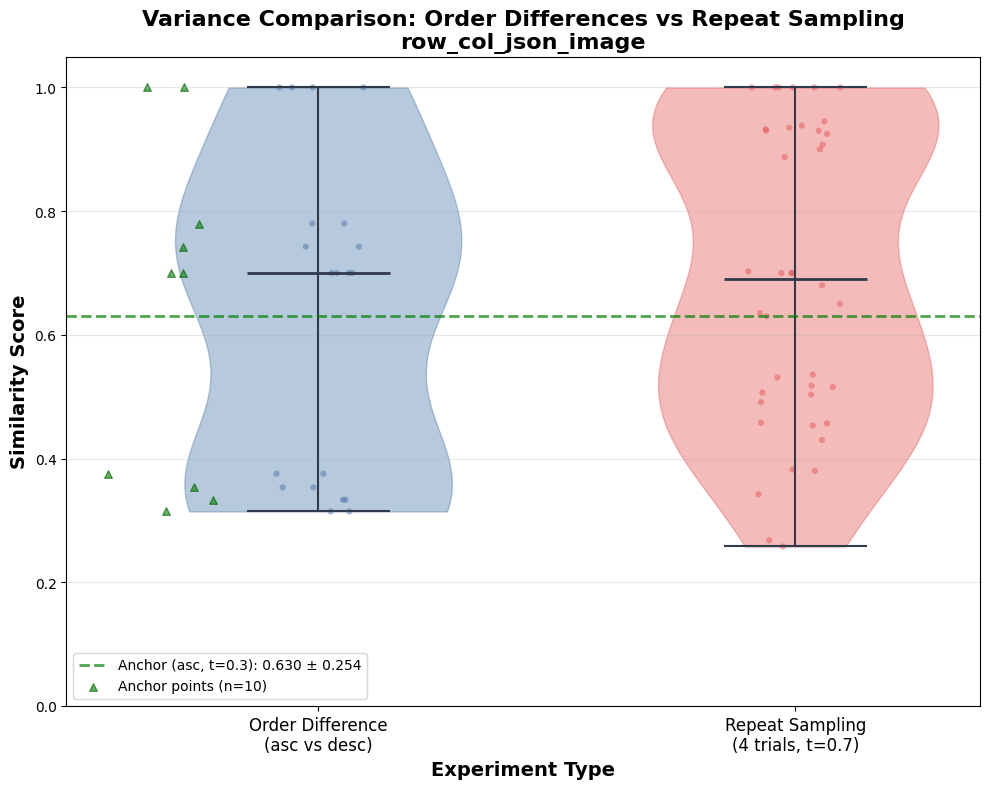

In [18]:
# Violin plot: Compare variance between order differences (asc/desc) vs repeat sampling (temperature randomness)
# for row_col_json_image modality

def create_order_vs_sampling_variance_plot(
    cross_order_data: Dict[str, Dict[str, List[Dict[str, Any]]]],
    repeat_sampling_results: List[Dict[str, Any]],
    save: bool = True
):
    """
    Create violin plot comparing variance from:
    1. Order differences (asc vs desc) - from cross-order experiment
    2. Repeat sampling (4 trials with same order, t=0.7) - from repeat sampling experiment
    3. Anchor point: existing row_col_json_image asc run from old data
    """
    modality = "row_col_json_image"
    
    # Extract scores from cross-order data (asc vs desc)
    order_diff_scores = []
    if modality in cross_order_data:
        data = cross_order_data[modality]
        variant_keys = ["held_out", "test", "held_out_reduced", "test_reduced"]
        for key in variant_keys:
            for item in data.get(key, []):
                # Get both asc and desc scores to show variance from order differences
                asc_score = item.get("asc_score")
                desc_score = item.get("desc_score")
                if asc_score is not None:
                    order_diff_scores.append(float(asc_score))
                if desc_score is not None:
                    order_diff_scores.append(float(desc_score))
    
    # Extract scores from repeat sampling experiment (4 trials)
    repeat_sampling_scores = []
    if repeat_sampling_results:
        for summary in repeat_sampling_results:
            trials = summary.get("trials", [])
            for trial in trials:
                result = trial.get("result", {})
                if result.get("modality_type") == modality:
                    # Extract all similarity scores from held_out and test results
                    for ho_result in result.get("held_out_results", []):
                        similarity = ho_result.get("similarity")
                        if similarity is not None:
                            repeat_sampling_scores.append(float(similarity))
                    for test_result in result.get("test_results", []):
                        similarity = test_result.get("similarity")
                        if similarity is not None:
                            repeat_sampling_scores.append(float(similarity))
                    for ho_result in result.get("held_out_results_reduced", []):
                        similarity = ho_result.get("similarity")
                        if similarity is not None:
                            repeat_sampling_scores.append(float(similarity))
                    for test_result in result.get("test_results_reduced", []):
                        similarity = test_result.get("similarity")
                        if similarity is not None:
                            repeat_sampling_scores.append(float(similarity))
    
    # Extract anchor point: existing row_col_json_image asc run from old data
    # This is the single asc run from 20251108_1455 (already loaded in new_results)
    anchor_scores = []
    for new_summary in new_results:
        result_data = new_summary.get("result", {})
        modality_type = result_data.get("modality_type") or new_summary.get("modality_type")
        if modality_type == modality:
            # Extract all similarity scores
            for ho_result in result_data.get("held_out_results", []):
                similarity = ho_result.get("similarity")
                if similarity is not None:
                    anchor_scores.append(float(similarity))
            for test_result in result_data.get("test_results", []):
                similarity = test_result.get("similarity")
                if similarity is not None:
                    anchor_scores.append(float(similarity))
            for ho_result in result_data.get("held_out_results_reduced", []):
                similarity = ho_result.get("similarity")
                if similarity is not None:
                    anchor_scores.append(float(similarity))
            for test_result in result_data.get("test_results_reduced", []):
                similarity = test_result.get("similarity")
                if similarity is not None:
                    anchor_scores.append(float(similarity))
            break  # Only need the first matching one
    
    # Prepare data for plotting
    plot_data = []
    labels = []
    
    if order_diff_scores:
        plot_data.append(order_diff_scores)
        labels.append("Order Difference\n(asc vs desc)")
    
    if repeat_sampling_scores:
        plot_data.append(repeat_sampling_scores)
        labels.append("Repeat Sampling\n(4 trials, t=0.7)")
    
    if not plot_data:
        print(f"No data found for {modality}")
        return None
    
    # Create plot
    fig, ax = plt.subplots(figsize=(10, 8))
    
    positions = np.arange(len(plot_data))
    
    # Create violin plot
    vp = ax.violinplot(
        plot_data,
        positions=positions,
        widths=0.6,
        showmeans=False,
        showextrema=True,
        showmedians=True,
    )
    
    # Style violins
    colors = ["#4C78A8", "#E45756"]  # Blue for order diff, Red for repeat sampling
    for i, body in enumerate(vp["bodies"]):
        color = colors[i % len(colors)]
        body.set_facecolor(color)
        body.set_edgecolor(color)
        body.set_alpha(0.4)
    
    if "cmedians" in vp:
        vp["cmedians"].set_color("#2F3A4A")
        vp["cmedians"].set_linewidth(2.0)
    if "cbars" in vp:
        vp["cbars"].set_color("#2F3A4A")
        vp["cbars"].set_linewidth(1.5)
    if "cmaxes" in vp:
        vp["cmaxes"].set_color("#2F3A4A")
        vp["cmaxes"].set_linewidth(1.5)
    if "cmins" in vp:
        vp["cmins"].set_color("#2F3A4A")
        vp["cmins"].set_linewidth(1.5)
    
    # Overlay jittered individual points
    rng = np.random.default_rng(42)
    for i, scores in enumerate(plot_data):
        if not scores:
            continue
        jitter = rng.uniform(-0.1, 0.1, size=len(scores))
        ax.scatter(
            np.full(len(scores), positions[i]) + jitter,
            scores,
            s=20,
            color=colors[i % len(colors)],
            alpha=0.5,
            edgecolors="none",
        )
    
    # Add anchor point as horizontal line or scatter
    if anchor_scores:
        anchor_mean = np.mean(anchor_scores)
        anchor_std = np.std(anchor_scores)
        # Draw horizontal line across all violins
        ax.axhline(y=anchor_mean, color='green', linestyle='--', linewidth=2, 
                   alpha=0.7, label=f'Anchor (asc, t=0.3): {anchor_mean:.3f} ± {anchor_std:.3f}')
        # Add scatter points for anchor scores
        anchor_jitter = rng.uniform(-0.15, 0.15, size=len(anchor_scores))
        ax.scatter(
            np.full(len(anchor_scores), -0.3) + anchor_jitter,
            anchor_scores,
            s=30,
            color='green',
            alpha=0.6,
            marker='^',
            edgecolors='darkgreen',
            linewidths=1,
            label=f'Anchor points (n={len(anchor_scores)})'
        )
    
    # Calculate and display variance statistics
    print(f"\nVariance Comparison for {modality}:")
    if order_diff_scores:
        print(f"  Order Difference (asc vs desc):")
        print(f"    Mean: {np.mean(order_diff_scores):.4f}, Std: {np.std(order_diff_scores):.4f}, Variance: {np.var(order_diff_scores):.4f}")
        print(f"    n={len(order_diff_scores)}")
    if repeat_sampling_scores:
        print(f"  Repeat Sampling (4 trials, t=0.7):")
        print(f"    Mean: {np.mean(repeat_sampling_scores):.4f}, Std: {np.std(repeat_sampling_scores):.4f}, Variance: {np.var(repeat_sampling_scores):.4f}")
        print(f"    n={len(repeat_sampling_scores)}")
    if anchor_scores:
        print(f"  Anchor (asc, t=0.3):")
        print(f"    Mean: {np.mean(anchor_scores):.4f}, Std: {np.std(anchor_scores):.4f}, Variance: {np.var(anchor_scores):.4f}")
        print(f"    n={len(anchor_scores)}")
    
    # Formatting
    ax.set_xlabel("Experiment Type", fontsize=14, fontweight='bold')
    ax.set_ylabel("Similarity Score", fontsize=14, fontweight='bold')
    ax.set_title(f"Variance Comparison: Order Differences vs Repeat Sampling\n{modality}", 
                 fontsize=16, fontweight='bold')
    ax.set_xticks(positions)
    ax.set_xticklabels(labels, fontsize=12)
    ax.set_ylim([0, 1.05])
    ax.grid(True, axis="y", alpha=0.3)
    ax.legend(loc='best', fontsize=10, frameon=True)
    
    plt.tight_layout()
    
    if save:
        filename = f"{modality}_order_vs_sampling_variance.png"
        filepath = PLOTS_DIR / filename
        plt.savefig(filepath, dpi=150, bbox_inches='tight')
        print(f"\n✓ Saved variance comparison plot: {filepath}")
    
    return fig

# Create the comparison plot
if repeat_sampling_results:
    print("\nCreating order vs sampling variance comparison plot...")
    fig_variance = create_order_vs_sampling_variance_plot(
        cross_order_data, 
        repeat_sampling_results, 
        save=True
    )
    plt.show()
else:
    print("\nCannot create variance comparison plot: repeat sampling data not available")
